In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
from sklearn.preprocessing import scale 
from sklearn.model_selection import KFold, train_test_split, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector

# Load Data #

### Load Immunization Data ###

In [2]:
# original data: <https://www.who.int/data/gho>

data_path = "../data/"

# 'Hepatitis B (HepB3) immunization coverage among 1-year-olds (%)'
data = pd.read_csv(f'{data_path}HepB3.csv')
HepB3 = data[['SpatialDimValueCode','Period','Value']]	

# 'Measles-containing-vaccine first-dose (MCV1) immunization coverage among 1-year-olds (%)'
data = pd.read_csv(f'{data_path}MCV1.csv')
MCV1 = data[['SpatialDimValueCode','Period','Value']]

# 'Measles-containing-vaccine second-dose (MCV2) immunization coverage by the nationally recommended age (%)'
data = pd.read_csv(f'{data_path}MCV2.csv')
MCV2 = data[['SpatialDimValueCode','Period','Value']]	

# 'BCG immunization coverage among 1-year-olds (%)'
data = pd.read_csv(f'{data_path}BCG.csv')
BCG = data[['SpatialDimValueCode','Period','Value']]	

# 'Polio (Pol3) immunization coverage among 1-year-olds (%)'
data = pd.read_csv(f'{data_path}Pol3.csv')
Pol3 = data[['SpatialDimValueCode','Period','Value']]	

In [3]:
immu = pd.merge(MCV1, MCV2, how='outer', on=['SpatialDimValueCode','Period'])
immu = immu.rename(columns={'Value_x': 'MCV1', 'Value_y': 'MCV2'})

immu = pd.merge(HepB3, immu, how='outer', on=['SpatialDimValueCode','Period'])
immu = immu.rename(columns={'Value': 'HepB3'})

immu = pd.merge(BCG, immu, how='outer', on=['SpatialDimValueCode','Period'])
immu = immu.rename(columns={'Value': 'BCG'})

immu = pd.merge(Pol3, immu, how='outer', on=['SpatialDimValueCode','Period'])
immu = immu.rename(columns={'Value': 'Pol3', 'SpatialDimValueCode': 'Country','Period':'Year'})

immu = immu[['Country','Year','HepB3','MCV1','MCV2','BCG','Pol3']]

In [4]:
immu.head(100)

Country  Year  HepB3  MCV1  MCV2   BCG  Pol3
0      PRK  2021   41.0    42  41.0  95.0   0.0
1      GNB  2021   67.0    63   NaN  34.0  23.0
2      PNG  2021   31.0    38  20.0  42.0  32.0
3      AGO  2021   41.0    36  32.0  56.0  43.0
4      MMR  2021   37.0    44  42.0  48.0  43.0
..     ...   ...    ...   ...   ...   ...   ...
95     JAM  2021   89.0    88  85.0  97.0  90.0
96     KGZ  2021   89.0    93  97.0  97.0  90.0
97     LTU  2021   90.0    88  88.0  93.0  90.0
98     NZL  2021   90.0    91  82.0   NaN  90.0
99     SMR  2021   90.0    89  81.0   NaN  90.0

[100 rows x 7 columns]

Text(0.5, 1.0, 'Polio (Pol3) immunization coverage among 1-year-olds (%) in 2021')

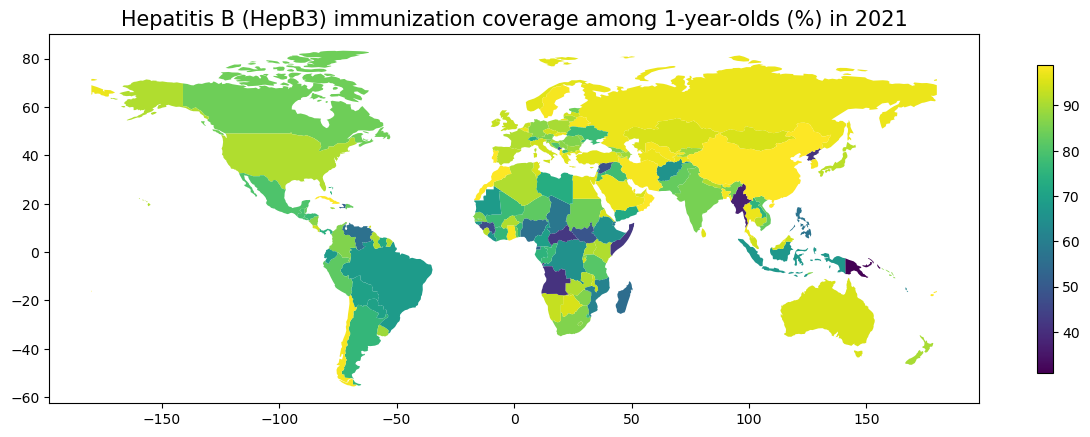

<Figure size 640x480 with 0 Axes>

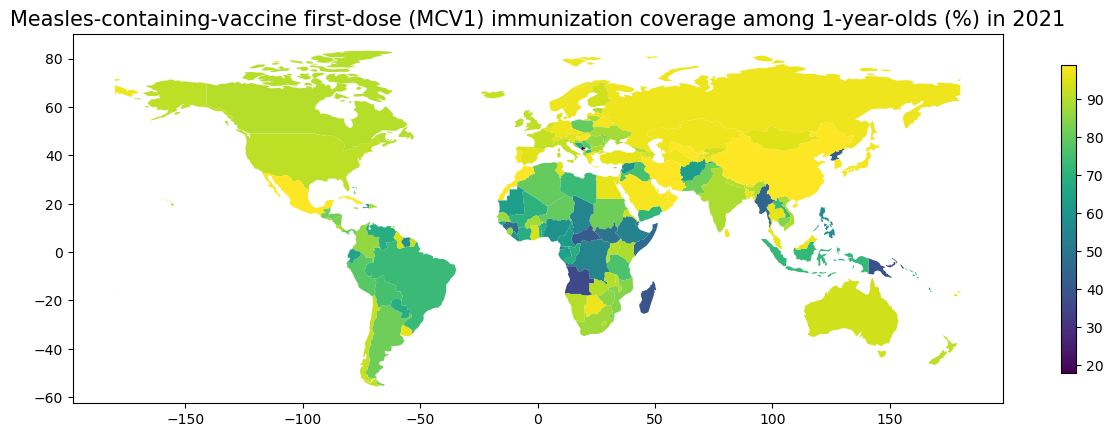

<Figure size 640x480 with 0 Axes>

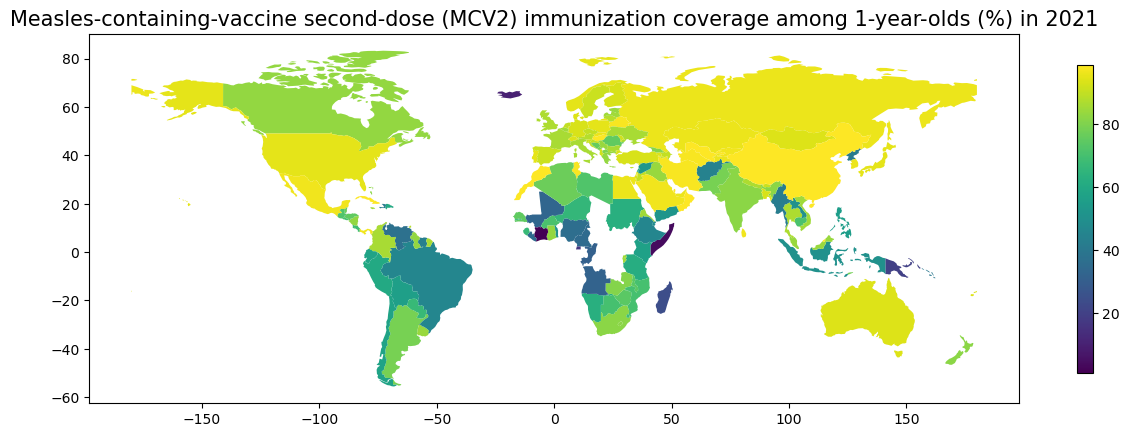

<Figure size 640x480 with 0 Axes>

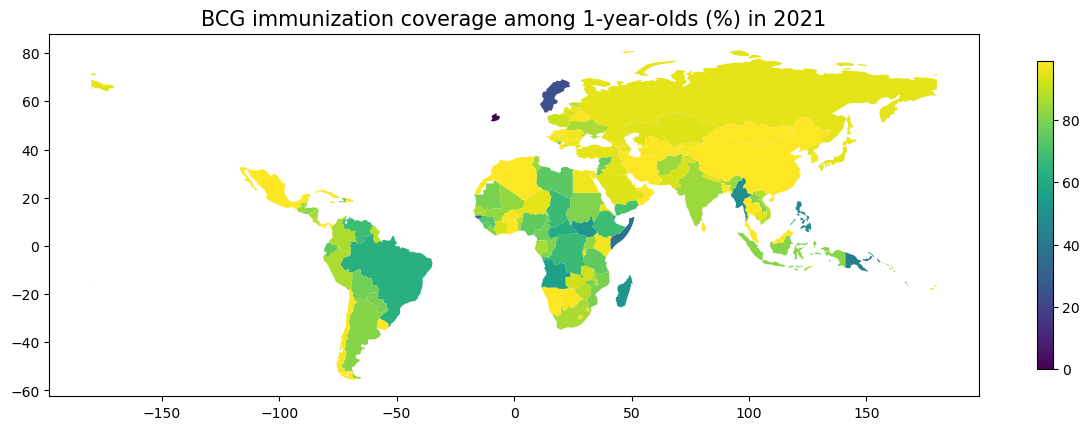

<Figure size 640x480 with 0 Axes>

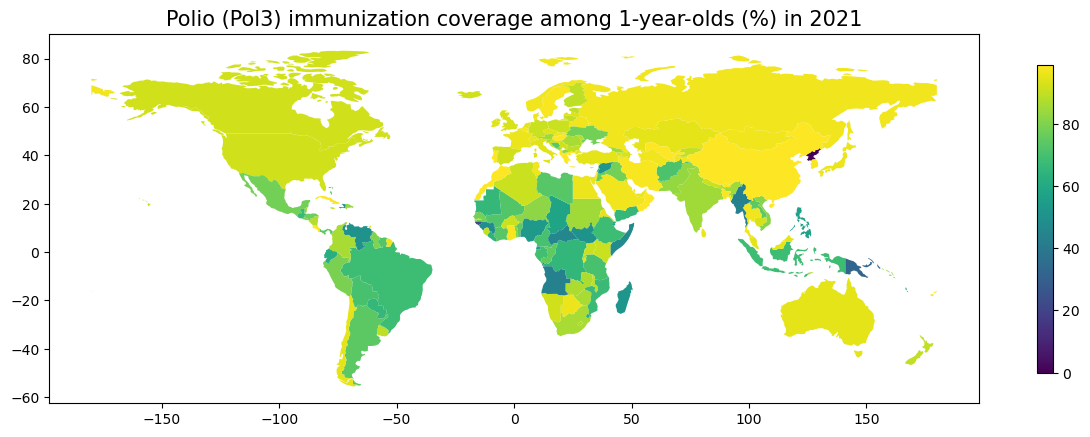

In [5]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

HepB3_2021 = immu[immu['Year']==2021][['Country','HepB3']].dropna()
HepB3_2021 = pd.merge(world, HepB3_2021, left_on='iso_a3',right_on='Country')
HepB3_2021.plot(column='HepB3',figsize=(15,10),legend=True, legend_kwds={'shrink': 0.4})
plt.title('Hepatitis B (HepB3) immunization coverage among 1-year-olds (%) in 2021',fontsize=15)

plt.figure()
MCV1_2021 = immu[immu['Year']==2021][['Country','MCV1']].dropna()
MCV1_2021 = pd.merge(world, MCV1_2021, left_on='iso_a3',right_on='Country')
MCV1_2021.plot(column='MCV1',figsize=(15,10),legend=True, legend_kwds={'shrink': 0.4})
plt.title('Measles-containing-vaccine first-dose (MCV1) immunization coverage among 1-year-olds (%) in 2021',fontsize=15)

plt.figure()
MCV2_2021 = immu[immu['Year']==2021][['Country','MCV2']].dropna()
MCV2_2021 = pd.merge(world, MCV2_2021, left_on='iso_a3',right_on='Country')
MCV2_2021.plot(column='MCV2',figsize=(15,10),legend=True, legend_kwds={'shrink': 0.4})
plt.title('Measles-containing-vaccine second-dose (MCV2) immunization coverage among 1-year-olds (%) in 2021',fontsize=15)

plt.figure()
BCG_2021 = immu[immu['Year']==2021][['Country','BCG']].dropna()
BCG_2021 = pd.merge(world, BCG_2021, left_on='iso_a3',right_on='Country')
BCG_2021.plot(column='BCG',figsize=(15,10),legend=True, legend_kwds={'shrink': 0.4})
plt.title('BCG immunization coverage among 1-year-olds (%) in 2021',fontsize=15)

plt.figure()
Pol3_2021 = immu[immu['Year']==2021][['Country','Pol3']].dropna()
Pol3_2021 = pd.merge(world, Pol3_2021, left_on='iso_a3',right_on='Country')
Pol3_2021.plot(column='Pol3',figsize=(15,10),legend=True, legend_kwds={'shrink': 0.4})
plt.title('Polio (Pol3) immunization coverage among 1-year-olds (%) in 2021',fontsize=15)

### Load Alcohol Consumption Data ###

In [6]:
# 'Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol)'
alc = pd.read_csv(f'{data_path}alc.csv', dtype={'Value':object})
# Filter alcohol consumption by alcohol type = total
alc = alc[alc['Dim1ValueCode']=='SA_TOTAL'][['SpatialDimValueCode','Period','FactValueNumeric']]
alc = alc.rename(columns={'SpatialDimValueCode': 'Country','Period':'Year','FactValueNumeric': 'AlcoholConsumption'})

In [7]:
alc.head(100)

Country  Year  AlcoholConsumption
9       BGD  2019                0.00
62      KWT  2019                0.00
77      MRT  2019                0.00
103     SAU  2019                0.00
112     SOM  2019                0.00
..      ...   ...                 ...
734     ECU  2019                3.05
735     CRI  2019                3.07
736     ISR  2019                3.07
738     IND  2019                3.09
739     ZWE  2019                3.11

[100 rows x 3 columns]

Text(0.5, 1.0, 'Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol) in 2019')

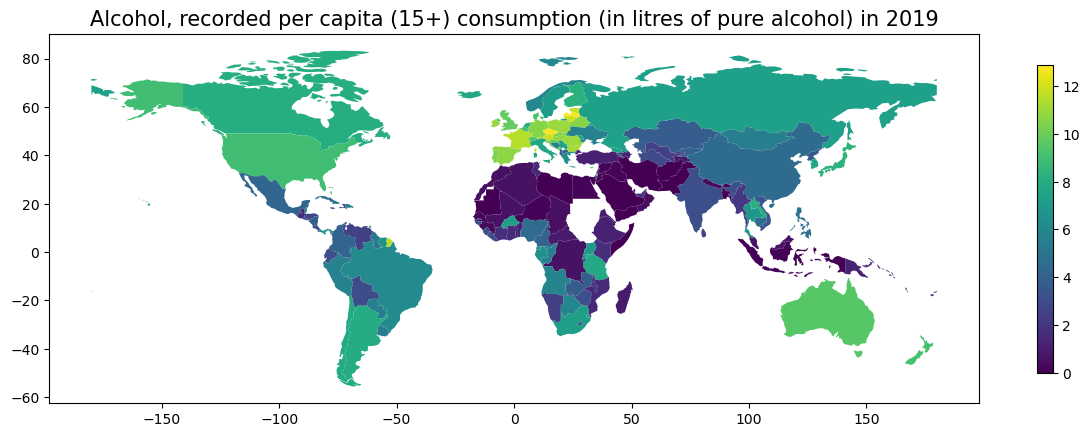

In [8]:
alc_2019 = alc[alc['Year']==2019][['Country','AlcoholConsumption']].dropna()
alc_2019 = pd.merge(world, alc_2019, left_on='iso_a3',right_on='Country')
alc_2019.plot(column='AlcoholConsumption',figsize=(15,10),legend=True, legend_kwds={'shrink': 0.4})
plt.title('Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol) in 2019',fontsize=15)

### Load Tobacco Prevalence Data ###

In [9]:
# 'Estimate of current tobacco smoking prevalence (%)'
data = pd.read_csv(f'{data_path}tob.csv')
# Filter tobacco prevalence by sex = both sex 
tob = data[(data['IndicatorCode']=='M_Est_smk_curr_std') & (data['Dim1']== 'Both sexes')][['SpatialDimValueCode','Period','Value']]
tob = tob.rename(columns={'SpatialDimValueCode': 'Country','Period':'Year','Value': 'TobaccoPrevalence'})

In [10]:
tob.head(100)

Country  Year  TobaccoPrevalence
552     ECU  2025               10.1
553     GTM  2025               10.1
556     COM  2025               10.5
557     BOL  2025               10.6
559     BHS  2025               10.7
..      ...   ...                ...
804     ETH  2025                3.4
808     BEN  2025                3.8
813     PAN  2025                3.9
814     MNE  2025               30.1
817     TUR  2025               30.4

[100 rows x 3 columns]

Text(0.5, 1.0, 'Tobacco use prevalence (%) in 2020')

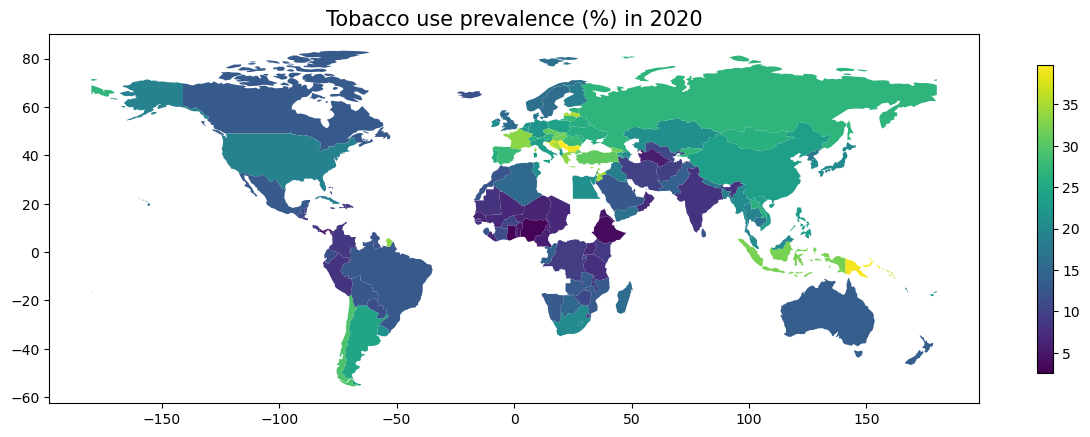

In [11]:
tob_2020 = tob[tob['Year']==2020][['Country','TobaccoPrevalence']].dropna()
tob_2020 = pd.merge(world, tob_2020, left_on='iso_a3',right_on='Country')
tob_2020.plot(column='TobaccoPrevalence',figsize=(15,10),legend=True, legend_kwds={'shrink': 0.4})
plt.title('Tobacco use prevalence (%) in 2020',fontsize=15)

### Load Health Expenditure Data ###

In [12]:
# Current health expenditure (CHE) per capita in PPP
data = pd.read_csv(f'{data_path}CHE_PPP.csv')
data.columns
che_ppp = data[['SpatialDimValueCode','Period','FactValueNumeric']]
che_ppp = che_ppp.rename(columns={'SpatialDimValueCode': 'Country','Period':'Year','FactValueNumeric': 'CHE_PPP'})

# Current health expenditure (CHE) as percentage of gross domestic product (GDP) (%)
data = pd.read_csv(f'{data_path}CHE_GDP.csv')
che_gdp = data[['SpatialDimValueCode','Period','FactValueNumeric']]
che_gdp = che_gdp.rename(columns={'SpatialDimValueCode': 'Country','Period':'Year','FactValueNumeric': 'CHE_GDP'})


In [13]:
che = pd.merge(che_ppp, che_gdp, how='outer', on=['Country','Year'])
che.head(100)

Country  Year  CHE_PPP  CHE_GDP
0      USA  2019  10921.0    16.77
1      ATG  2019   1016.0     4.44
2      BRB  2019   1029.0     6.30
3      DJI  2019    104.1     1.80
4      PNG  2019    104.6     2.30
..     ...   ...      ...      ...
95     ISR  2019   3326.0     7.46
96     CZE  2019   3477.0     7.83
97     PRT  2019   3518.0     9.53
98     KOR  2019   3521.0     8.16
99     IDN  2019    358.3     2.90

[100 rows x 4 columns]

Text(0.5, 1.0, 'Health expenditure (CHE) per capita in GDP in 2019')

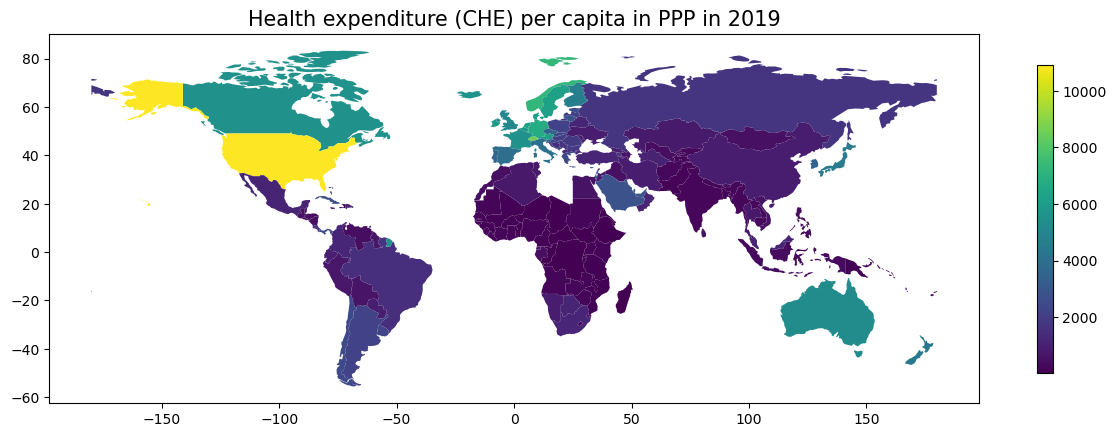

<Figure size 640x480 with 0 Axes>

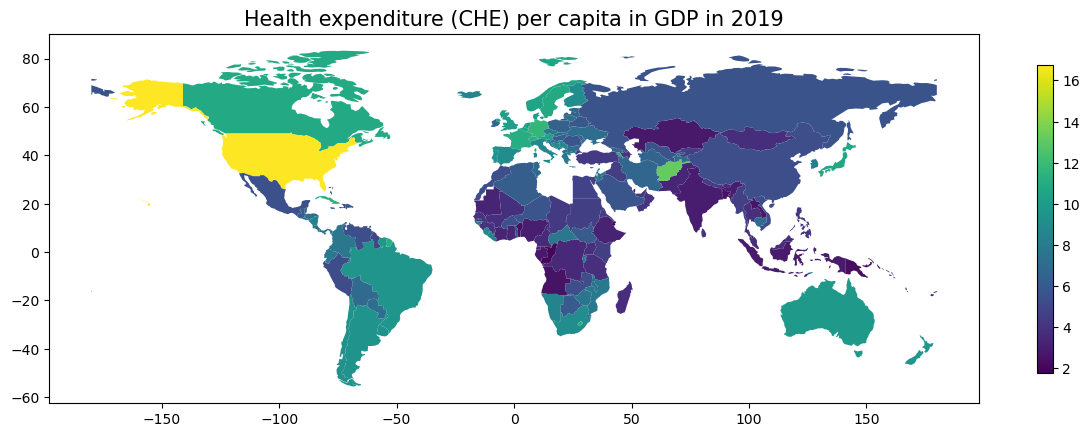

In [14]:
CHE_PPP_2019 = che[che['Year']==2019][['Country','CHE_PPP']].dropna()
CHE_PPP_2019 = pd.merge(world, CHE_PPP_2019, left_on='iso_a3',right_on='Country')
CHE_PPP_2019.plot(column='CHE_PPP',figsize=(15,10),legend=True, legend_kwds={'shrink': 0.4})
plt.title('Health expenditure (CHE) per capita in PPP in 2019',fontsize=15)

plt.figure()
CHE_GDP_2019 = che[che['Year']==2019][['Country','CHE_GDP']].dropna()
CHE_GDP_2019 = pd.merge(world, CHE_GDP_2019, left_on='iso_a3',right_on='Country')
CHE_GDP_2019.plot(column='CHE_GDP',figsize=(15,10),legend=True, legend_kwds={'shrink': 0.4})
plt.title('Health expenditure (CHE) per capita in GDP in 2019',fontsize=15)

### Load Under-/Overweight/Obesity Prevalence ###

In [15]:
# Prevalence of underweight among adults, BMI < 18 (age-standardized estimate) (%)
data = pd.read_csv(f'{data_path}underweight.csv')
# Filter underweight prevalence by sex = both sex
underweight = data[data['Dim1']=='Both sexes'][['SpatialDimValueCode','Period','FactValueNumeric']]
underweight = underweight.rename(columns={'SpatialDimValueCode': 'Country','Period':'Year','FactValueNumeric': 'UnderweightPrevalence'})

# Prevalence of overweight among adults, BMI >= 25 (age-standardized estimate) (%)
data = pd.read_csv(f'{data_path}overweight.csv')
# Filter overweight prevalence by sex = both sex
overweight = data[data['Dim1']=='Both sexes'][['SpatialDimValueCode','Period','FactValueNumeric']]
overweight = overweight.rename(columns={'SpatialDimValueCode': 'Country','Period':'Year','FactValueNumeric':'OverweightPrevalence'})

# Prevalence of obesity among adults, BMI >= 30 (age-standardized estimate) (%)
data = pd.read_csv(f'{data_path}obesity.csv')
# Filter overweight prevalence by sex = both sex
obesity = data[data['Dim1']=='Both sexes'][['SpatialDimValueCode','Period','FactValueNumeric']]
obesity = obesity.rename(columns={'SpatialDimValueCode': 'Country','Period':'Year','FactValueNumeric': 'ObesityPrevalence'})

In [16]:
abn_wgt = pd.merge(underweight, overweight, how='outer', on=['Year','Country'])
abn_wgt = pd.merge(obesity, abn_wgt, how='outer', on=['Year','Country'])

In [17]:
abn_wgt.head(100)

Country  Year  ObesityPrevalence  UnderweightPrevalence  \
0      THA  2016               10.0                    8.6   
1      GMB  2016               10.3                   10.0   
2      CIV  2016               10.3                    8.0   
3      MUS  2016               10.8                    8.1   
4      GHA  2016               10.9                    8.7   
..     ...   ...                ...                    ...   
95     CZE  2016               26.0                    1.0   
96     MAR  2016               26.1                    3.1   
97     ISR  2016               26.1                    1.0   
98     LTU  2016               26.3                    1.0   
99     SUR  2016               26.4                    3.3   

    OverweightPrevalence  
0                   32.6  
1                   31.9  
2                   31.6  
3                   32.3  
4                   32.0  
..                   ...  
95                  62.3  
96                  60.4  
97                  64.3  
98                  59.6  
99                  58.9  

[100 rows x 5 columns]

Text(0.5, 1.0, 'Prevalence of obesity among adults, BMI >= 30 (age-standardized estimate) (%) in 2016')

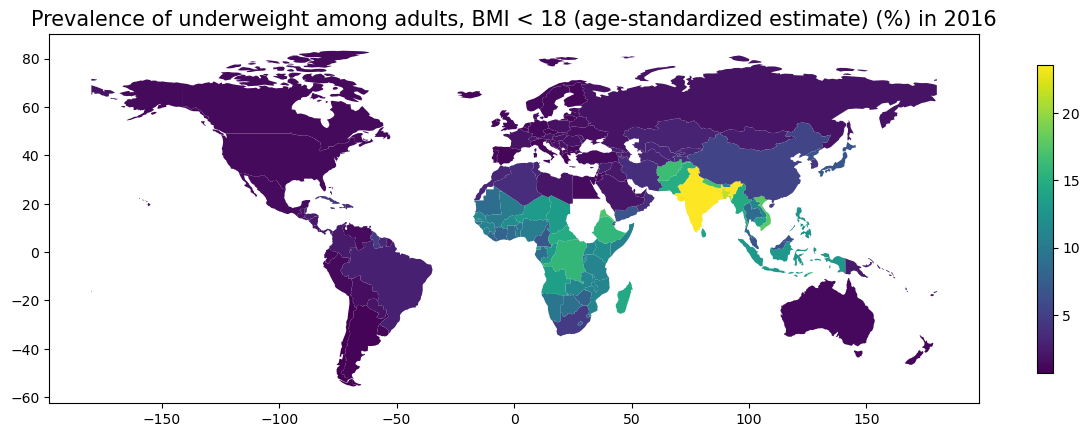

<Figure size 640x480 with 0 Axes>

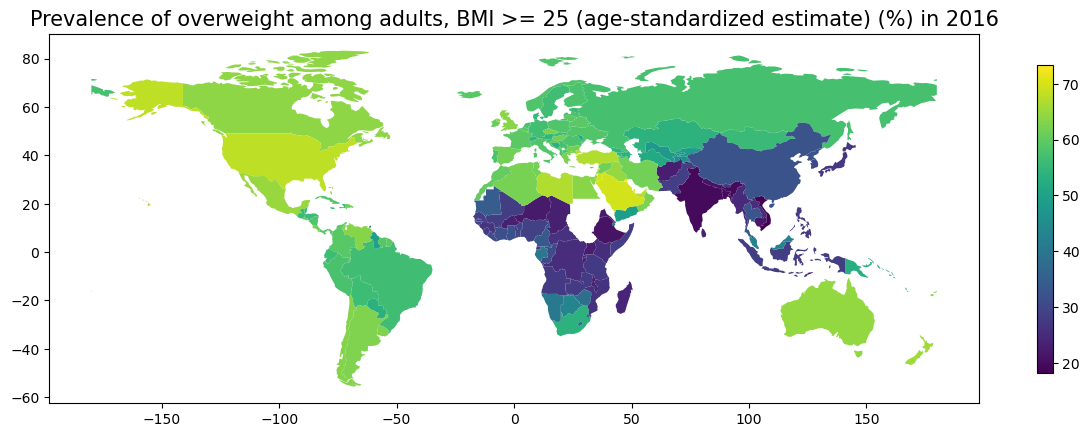

<Figure size 640x480 with 0 Axes>

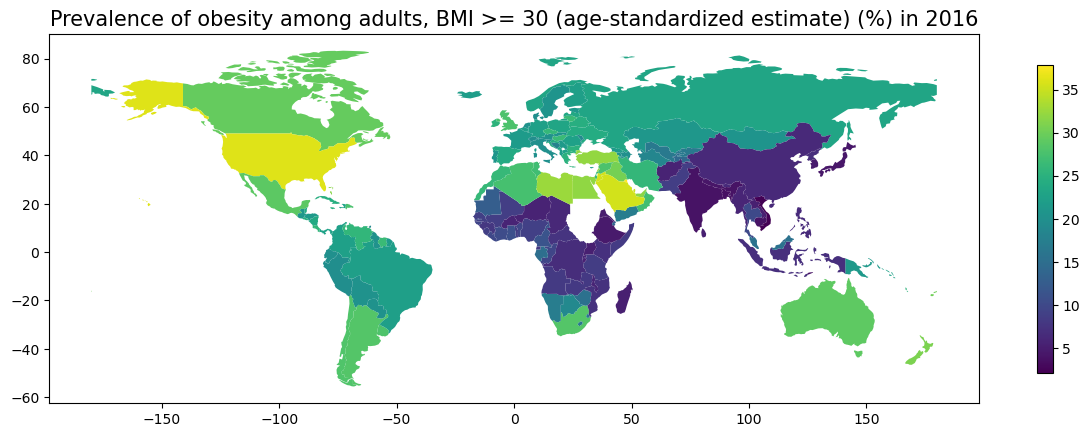

In [18]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

underweight_2016 = underweight[underweight['Year']==2016][['Country','UnderweightPrevalence']].dropna()
underweight_2016 = pd.merge(world, underweight_2016, left_on='iso_a3',right_on='Country')
underweight_2016.plot(column='UnderweightPrevalence',figsize=(15,10),legend=True, legend_kwds={'shrink': 0.4})
plt.title('Prevalence of underweight among adults, BMI < 18 (age-standardized estimate) (%) in 2016',fontsize=15)

plt.figure()
overweight_2016 = overweight[overweight['Year']==2016][['Country','OverweightPrevalence']].dropna()
overweight_2016 = pd.merge(world, overweight_2016, left_on='iso_a3',right_on='Country')
overweight_2016.plot(column='OverweightPrevalence',figsize=(15,10),legend=True, legend_kwds={'shrink': 0.4})
plt.title('Prevalence of overweight among adults, BMI >= 25 (age-standardized estimate) (%) in 2016',fontsize=15)

plt.figure()
obesity_2016 = obesity[obesity['Year']==2016][['Country','ObesityPrevalence']].dropna()
obesity_2016 = pd.merge(world, obesity_2016, left_on='iso_a3',right_on='Country')
obesity_2016.plot(column='ObesityPrevalence',figsize=(15,10),legend=True, legend_kwds={'shrink': 0.4})
plt.title('Prevalence of obesity among adults, BMI >= 30 (age-standardized estimate) (%) in 2016',fontsize=15)

### Load Life Expectancy Data ###

In [19]:
# 'Life expectancy at birth (years)'
data = pd.read_csv(f'{data_path}life_exp.csv')
# Filter life expectancy by sex = both sex
life_exp = data[(data['Dim1']=='Both sexes') & (data['IndicatorCode']== 'WHOSIS_000001')][['SpatialDimValueCode','Period','Value']]
life_exp = life_exp.rename(columns={'SpatialDimValueCode': 'Country','Period':'Year','Value': 'LifeExpectancy'})

In [20]:
life_exp.head(100)

Country  Year  LifeExpectancy
2       LSO  2019           50.75
3       CAF  2019           53.10
10      SOM  2019           56.47
13      SWZ  2019           57.73
15      MOZ  2019           58.14
..      ...   ...             ...
289     CPV  2019           74.03
291     MUS  2019           74.07
294     KGZ  2019           74.18
296     BGD  2019           74.25
299     SAU  2019           74.31

[100 rows x 3 columns]

In [21]:
life_exp[life_exp['Year']==2015]

Country  Year  LifeExpectancy
1099     LSO  2015           47.67
1102     CAF  2015           50.53
1107     SWZ  2015           54.05
1108     SOM  2015           54.57
1113     MOZ  2015           55.95
...      ...   ...             ...
1611     LUX  2015           82.31
1612     ESP  2015           82.33
1616     CHE  2015           82.61
1618     SGP  2015           82.81
1631     JPN  2015           83.62

[183 rows x 3 columns]

Text(0.5, 1.0, 'Life expectancy at birth (years) in 2019')

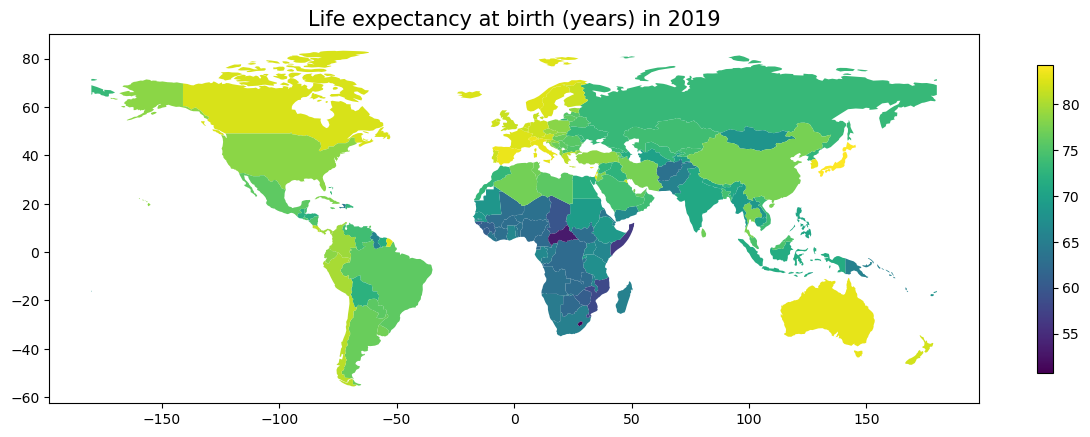

In [22]:
life_exp_2019 = life_exp[life_exp['Year']==2019][['Country','LifeExpectancy']].dropna()
life_exp_2019 = pd.merge(world, life_exp_2019, left_on='iso_a3',right_on='Country')
life_exp_2019.plot(column='LifeExpectancy',figsize=(15,10),legend=True, legend_kwds={'shrink': 0.4})
plt.title('Life expectancy at birth (years) in 2019',fontsize=15)

# Data Preprocessing #

In [23]:
data = pd.merge(immu, alc, how='outer', on=['Country','Year'])
data = data.merge(tob, how='outer', on=['Country','Year'])
data = data.merge(che, how='outer', on=['Country','Year'])
data = data.merge(abn_wgt, how='outer', on=['Country','Year'])
data = data.merge(life_exp, how='outer', on=['Country','Year'])
# Drop NaN values
data_dropna = data.dropna()
data = data[(data['Year']>=2000) & (data['Year']<=2022)].groupby(['Country']).transform(lambda x: x.fillna(x.mean())).dropna()

In [24]:
# Check duplicates
num_dup = np.sum(data.duplicated())
print(num_dup)

data

0


Year    HepB3   MCV1       MCV2   BCG    Pol3  AlcoholConsumption  \
2      2021  31.0000  38.00  20.000000  42.0  32.000            0.893500   
4      2021  37.0000  44.00  42.000000  48.0  43.000            1.004000   
10     2021  51.0000  65.00  41.000000  73.0  51.000            3.147000   
11     2021  55.0000  39.00  24.000000  52.0  52.000            0.844500   
13     2021  56.0000  59.00  36.000000  75.0  53.000            7.867500   
...     ...      ...    ...        ...   ...     ...                 ...   
10963  2000  79.6875  67.25  90.133333  89.5  89.875            9.612857   
10982  2004  79.6875  67.25  90.133333  89.5  89.875            9.612857   
10985  2003  79.6875  67.25  90.133333  89.5  89.875            9.612857   
10988  2002  79.6875  67.25  90.133333  89.5  89.875            9.612857   
10991  2001  79.6875  67.25  90.133333  89.5  89.875            9.612857   

       TobaccoPrevalence      CHE_PPP   CHE_GDP  ObesityPrevalence  \
2              44.571429    72.071000  2.410000          17.052941   
4              26.528571    99.700500  3.072000           3.729412   
10              9.314286   112.731000  4.249500          16.400000   
11             18.857143    68.215000  4.577000           3.605882   
13              4.342857   156.539000  3.616500           6.188235   
...                  ...          ...       ...                ...   
10963          38.700000  1462.111111  8.337778          16.200000   
10982          34.300000  1462.111111  8.337778          18.100000   
10985          34.300000  1462.111111  8.337778          17.600000   
10988          34.300000  1462.111111  8.337778          17.100000   
10991          34.300000  1462.111111  8.337778          16.600000   

       UnderweightPrevalence  OverweightPrevalence  LifeExpectancy  
2                   2.905882             47.458824         64.1250  
4                  17.376471             19.511765         65.3725  
10                  5.911765             46.194118         53.7475  
11                 16.294118             19.629412         62.7875  
13                 11.952941             23.782353         59.1625  
...                      ...                   ...             ...  
10963               2.100000             50.300000         73.5600  
10982               1.900000             53.000000         74.8500  
10985               2.000000             52.400000         74.8500  
10988               2.000000             51.700000         74.8500  
10991               2.100000             51.000000         74.8500  

[2706 rows x 14 columns]

In [25]:
# Check duplicates
num_dup = np.sum(data_dropna.duplicated())
print(num_dup)

data_dropna

0


Country  Year  HepB3  MCV1  MCV2   BCG  Pol3  AlcoholConsumption  \
1177     UKR  2015   22.0  56.0  57.0  39.0  51.0                6.04   
1181     YEM  2015   69.0  67.0  41.0  47.0  63.0                0.03   
1184     AFG  2015   64.0  62.0  42.0  76.0  67.0                0.00   
1192     IRQ  2015   68.0  71.0  76.0  94.0  72.0                0.16   
1193     PAK  2015   72.0  75.0  54.0  86.0  72.0                0.04   
...      ...   ...    ...   ...   ...   ...   ...                 ...   
4255     KGZ  2000   44.0  98.0  96.0  96.0  99.0                5.33   
4259     OMN  2000   99.0  99.0  99.0  98.0  99.0                0.38   
4261     KOR  2000   93.0  95.0  39.0  73.0  99.0               10.33   
4262     ROU  2000   98.0  98.0  96.0  99.0  99.0                9.00   
4267     UKR  2000    4.0  99.0  99.0  98.0  99.0                6.95   

      TobaccoPrevalence  CHE_PPP  CHE_GDP  ObesityPrevalence  \
1177               28.4    753.9     7.78               23.7   
1181               17.9    110.0     4.25               16.5   
1184               11.5    211.6    10.11                5.2   
1192               19.1    326.6     3.14               29.8   
1193               15.7    117.5     2.69                8.2   
...                 ...      ...      ...                ...   
4255               27.4     81.9     4.41                9.6   
4259                6.9   1102.0     3.06               18.0   
4261               35.0    716.9     3.90                2.9   
4262               35.0    246.1     4.21               16.2   
4267               37.7    227.0     5.31               19.1   

      UnderweightPrevalence  OverweightPrevalence  LifeExpectancy  
1177                    1.5                  58.0           72.20  
1181                    6.9                  48.0           67.47  
1184                   16.8                  22.3           61.65  
1192                    2.3                  64.1           70.29  
1193                   15.3                  27.7           64.18  
...                     ...                   ...             ...  
4255                    4.6                  38.3           65.95  
4259                    5.8                  51.8           69.07  
4261                    5.5                  24.6           76.21  
4262                    2.3                  49.8           71.39  
4267                    1.9                  52.2           67.53  

[195 rows x 15 columns]

# Data Description #

In [26]:
data.dtypes

Year                       int64
HepB3                    float64
MCV1                     float64
MCV2                     float64
BCG                      float64
Pol3                     float64
AlcoholConsumption       float64
TobaccoPrevalence        float64
CHE_PPP                  float64
CHE_GDP                  float64
ObesityPrevalence        float64
UnderweightPrevalence    float64
OverweightPrevalence     float64
LifeExpectancy           float64
dtype: object

In [27]:
data.describe()

Year        HepB3         MCV1         MCV2          BCG  \
count  2706.000000  2706.000000  2706.000000  2706.000000  2706.000000   
mean   2010.500000    86.167298    86.725092    74.961433    91.247292   
std       6.345461    15.047608    13.845453    24.471254    11.780802   
min    2000.000000     2.000000    18.000000     1.000000    16.000000   
25%    2005.000000    81.000000    81.000000    59.375000    89.000000   
50%    2010.500000    91.000000    92.000000    85.000000    96.000000   
75%    2016.000000    96.000000    97.000000    95.000000    99.000000   
max    2021.000000    99.000000    99.000000    99.000000    99.000000   

              Pol3  AlcoholConsumption  TobaccoPrevalence      CHE_PPP  \
count  2706.000000         2706.000000        2706.000000  2706.000000   
mean     87.710920            4.241024          20.676655   709.284617   
std      12.859932            3.685627          10.033389   837.776310   
min      24.000000            0.000000           2.600000    10.610000   
25%      83.000000            1.010000          12.500000   146.124375   
50%      93.000000            3.455000          19.700000   399.100000   
75%      97.000000            6.514500          27.571429   946.925000   
max      99.000000           17.870000          68.500000  6223.000000   

           CHE_GDP  ObesityPrevalence  UnderweightPrevalence  \
count  2706.000000        2706.000000            2706.000000   
mean      5.814617          14.580823               7.133381   
std       2.299401           9.193192               6.042617   
min       1.510000           0.600000               0.300000   
25%       4.130000           5.894118               2.000000   
50%       5.446000          15.300000               4.623529   
75%       7.280000          20.600000              11.600000   
max      20.410000          48.200000              29.500000   

       OverweightPrevalence  LifeExpectancy  
count           2706.000000     2706.000000  
mean              41.253993       69.314268  
std               16.624698        7.778156  
min               10.100000       31.280000  
25%               24.500000       63.127500  
50%               46.400000       70.763750  
75%               54.747059       75.455000  
max               78.700000       84.260000

Text(0.5, 1.0, 'Abnormal weight prevalence')

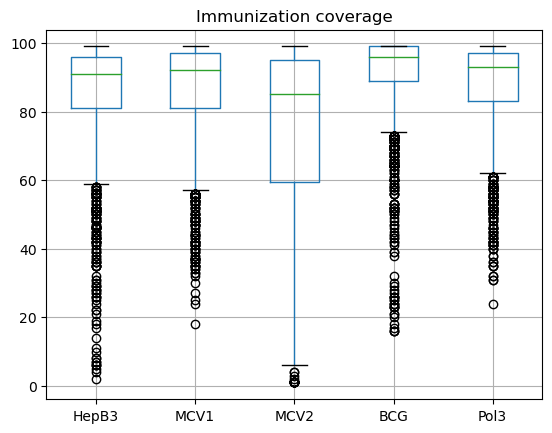

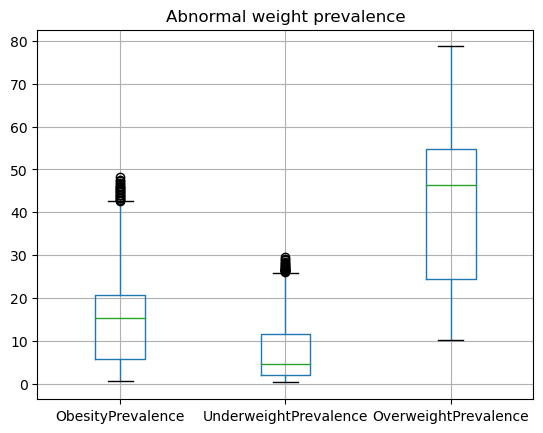

In [28]:
data.boxplot(column=['HepB3','MCV1','MCV2','BCG','Pol3'])  
plt.title('Immunization coverage')
plt.figure()
data.boxplot(column=['ObesityPrevalence','UnderweightPrevalence','OverweightPrevalence'])  
plt.title('Abnormal weight prevalence')

In [29]:
data

Year    HepB3   MCV1       MCV2   BCG    Pol3  AlcoholConsumption  \
2      2021  31.0000  38.00  20.000000  42.0  32.000            0.893500   
4      2021  37.0000  44.00  42.000000  48.0  43.000            1.004000   
10     2021  51.0000  65.00  41.000000  73.0  51.000            3.147000   
11     2021  55.0000  39.00  24.000000  52.0  52.000            0.844500   
13     2021  56.0000  59.00  36.000000  75.0  53.000            7.867500   
...     ...      ...    ...        ...   ...     ...                 ...   
10963  2000  79.6875  67.25  90.133333  89.5  89.875            9.612857   
10982  2004  79.6875  67.25  90.133333  89.5  89.875            9.612857   
10985  2003  79.6875  67.25  90.133333  89.5  89.875            9.612857   
10988  2002  79.6875  67.25  90.133333  89.5  89.875            9.612857   
10991  2001  79.6875  67.25  90.133333  89.5  89.875            9.612857   

       TobaccoPrevalence      CHE_PPP   CHE_GDP  ObesityPrevalence  \
2              44.571429    72.071000  2.410000          17.052941   
4              26.528571    99.700500  3.072000           3.729412   
10              9.314286   112.731000  4.249500          16.400000   
11             18.857143    68.215000  4.577000           3.605882   
13              4.342857   156.539000  3.616500           6.188235   
...                  ...          ...       ...                ...   
10963          38.700000  1462.111111  8.337778          16.200000   
10982          34.300000  1462.111111  8.337778          18.100000   
10985          34.300000  1462.111111  8.337778          17.600000   
10988          34.300000  1462.111111  8.337778          17.100000   
10991          34.300000  1462.111111  8.337778          16.600000   

       UnderweightPrevalence  OverweightPrevalence  LifeExpectancy  
2                   2.905882             47.458824         64.1250  
4                  17.376471             19.511765         65.3725  
10                  5.911765             46.194118         53.7475  
11                 16.294118             19.629412         62.7875  
13                 11.952941             23.782353         59.1625  
...                      ...                   ...             ...  
10963               2.100000             50.300000         73.5600  
10982               1.900000             53.000000         74.8500  
10985               2.000000             52.400000         74.8500  
10988               2.000000             51.700000         74.8500  
10991               2.100000             51.000000         74.8500  

[2706 rows x 14 columns]

# Linear Regression #

In [30]:
# Saves regressor performance (Baseline+univariante+multivariante regressor, training/test mse, data dropNaN/fill average)
mse_reg = np.zeros((14, 2, 2))
mse_reg_std = np.zeros((14, 2, 2))

## Mean value as baseline predictor ##

In [31]:
# Data that fills the NaN value with average value
X = data.drop(['LifeExpectancy','Year'], axis=1)
features = X.columns
y = data['LifeExpectancy'].to_numpy()
X = scale(X)

# Do multiple train-test split against noisy split to measure the performance
splits = ShuffleSplit(n_splits=100, test_size=0.2, train_size=0.8, random_state=42)
mse_train = np.zeros(splits.get_n_splits())
mse_test = np.zeros(splits.get_n_splits())

# Apply univariante linear regression on each train-test split
for i, (train_index, test_index) in enumerate(splits.split(X, y)):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    
    # Use dummy mean value as prediction
    y_pred_train = y_train.mean() * np.ones_like(y_train) 
    y_pred_test = y_train.mean() * np.ones_like(y_test)
    
    # Compute the training and test MSE 
    mse_train[i] = mean_squared_error(y_train, y_pred_train)
    mse_test[i] = mean_squared_error(y_test, y_pred_test)


In [32]:
mse_train_std = mse_train.std()
mse_test_std = mse_test.std()
mse_reg_std[13,0,0] = mse_train_std
mse_reg_std[13,1,0] = mse_test_std
print(f'training_mse: {mse_train_std}, test_mse: {mse_test_std}')

training_mse: 0.7127989481635056, test_mse: 2.8500649760656587


In [33]:
mse_train = mse_train.mean()
mse_test = mse_test.mean()
mse_reg[13,0,0] = mse_train
mse_reg[13,1,0] = mse_test
print(f'training_mse: {mse_train}, test_mse: {mse_test}')

training_mse: 60.48639619561933, test_mse: 60.46645881368292


In [34]:
# Data that simply drops the NaN value
X = data_dropna.drop(['LifeExpectancy','Year','Country'], axis=1)
features = X.columns
y = data_dropna['LifeExpectancy'].to_numpy()
X = scale(X)

# Do multiple train-test split against noisy split to measure the performance
splits = ShuffleSplit(n_splits=100, test_size=0.2, train_size=0.8, random_state=42)
mse_train = np.zeros(splits.get_n_splits())
mse_test = np.zeros(splits.get_n_splits())

# Apply univariante linear regression on each train-test split
for i, (train_index, test_index) in enumerate(splits.split(X, y)):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    
    # Use dummy mean value as prediction
    y_pred_train = y_train.mean() * np.ones_like(y_train) 
    y_pred_test = y_train.mean() * np.ones_like(y_test)
    
    # Compute the training and test MSE 
    mse_train[i] = mean_squared_error(y_train, y_pred_train)
    mse_test[i] = mean_squared_error(y_test, y_pred_test)



In [35]:
mse_train_std = mse_train.std()
mse_test_std = mse_test.std()
mse_reg_std[13,0,1] = mse_train_std
mse_reg_std[13,1,1] = mse_test_std
print(f'mse_train_std: {mse_train_std}, mse_test_std: {mse_test_std}')

mse_train_std: 3.3952673436451772, mse_test_std: 13.686649816732032


In [36]:
mse_train = mse_train.mean()
mse_test = mse_test.mean()
mse_reg[13,0,1] = mse_train
mse_reg[13,1,1] = mse_test
print(f'training_mse: {mse_train}, test_mse: {mse_test}')

training_mse: 39.878277771655156, test_mse: 41.876878898463175


## Univariate Linear Regression ##

HepB3: reg_coef: [2.22582184], reg.intercept_: 69.43851728622643
MCV1: reg_coef: [4.01042669], reg.intercept_: 69.43394559832504
MCV2: reg_coef: [4.58742816], reg.intercept_: 69.43125397632375
BCG: reg_coef: [1.69841488], reg.intercept_: 69.4324259950529
Pol3: reg_coef: [3.93092732], reg.intercept_: 69.41928359028668
AlcoholConsumption: reg_coef: [2.42144904], reg.intercept_: 69.4154282840879
TobaccoPrevalence: reg_coef: [2.43991449], reg.intercept_: 69.41404102036395
CHE_PPP: reg_coef: [4.64519573], reg.intercept_: 69.35815803122671
CHE_GDP: reg_coef: [0.87863844], reg.intercept_: 69.42040514137652
ObesityPrevalence: reg_coef: [2.92775541], reg.intercept_: 69.37707299852327
UnderweightPrevalence: reg_coef: [-4.03910214], reg.intercept_: 69.33463726029689
OverweightPrevalence: reg_coef: [3.94665558], reg.intercept_: 69.34755561397895


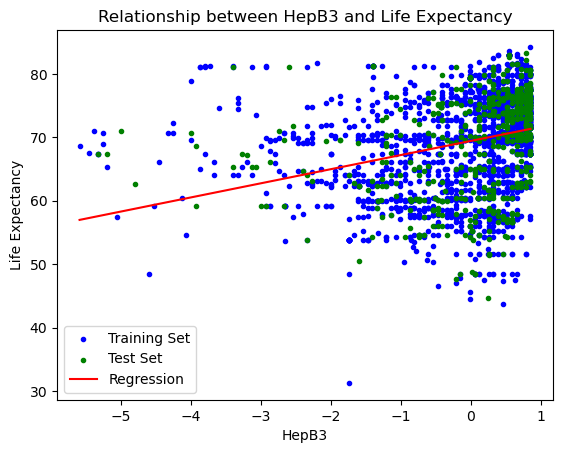

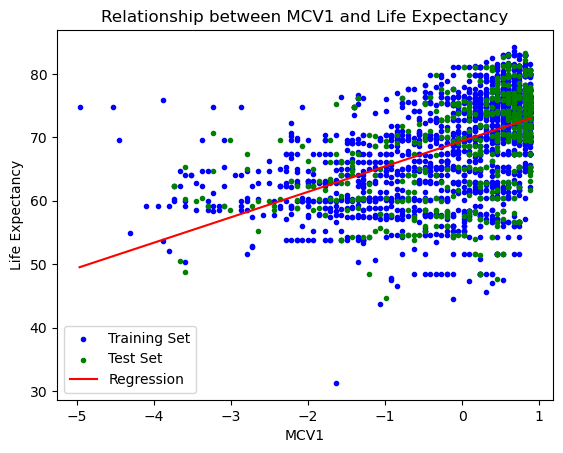

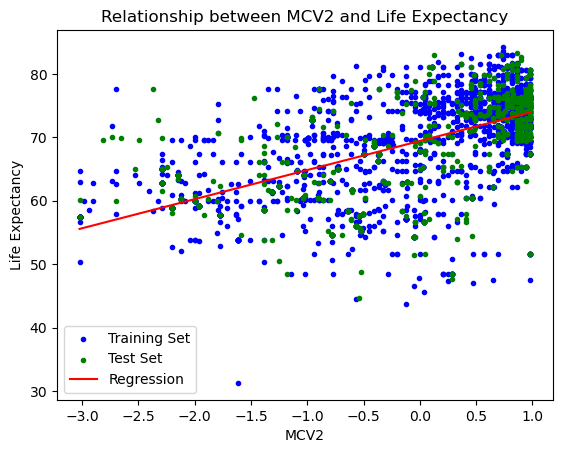

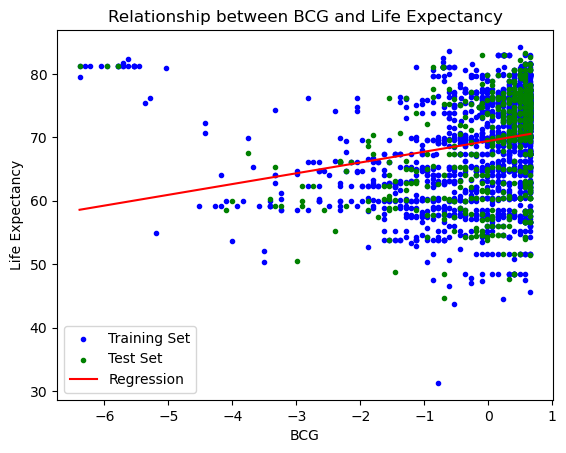

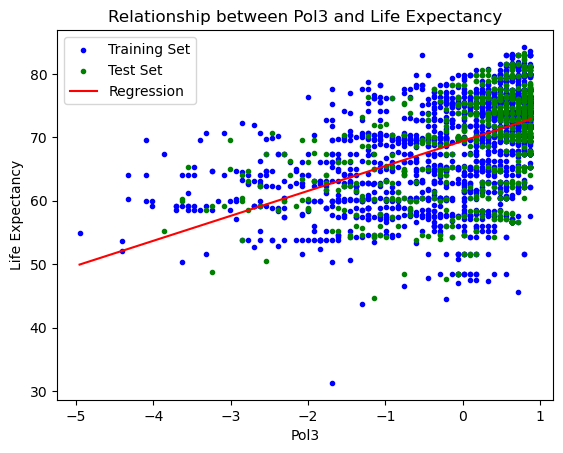

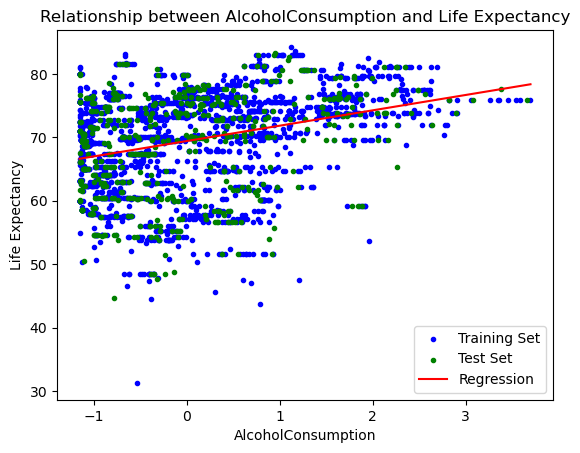

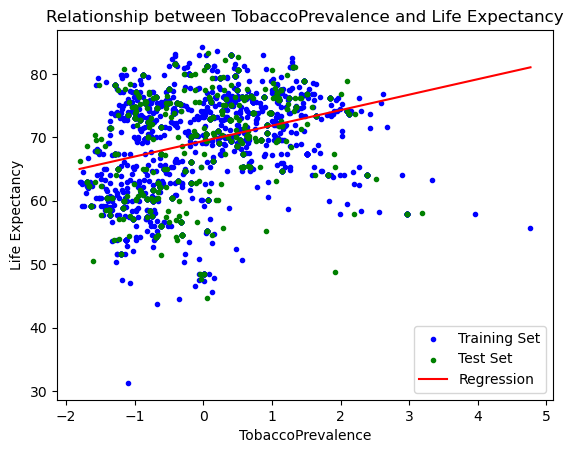

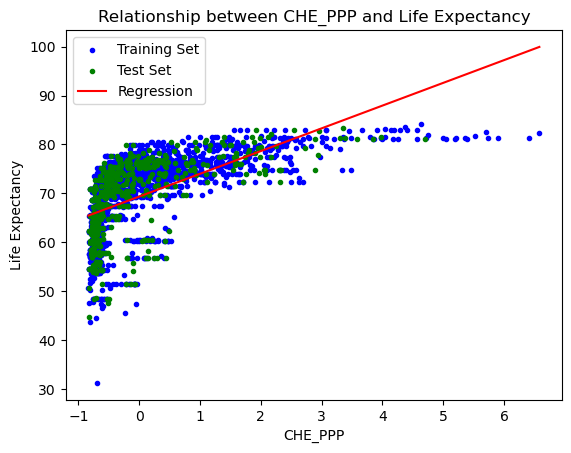

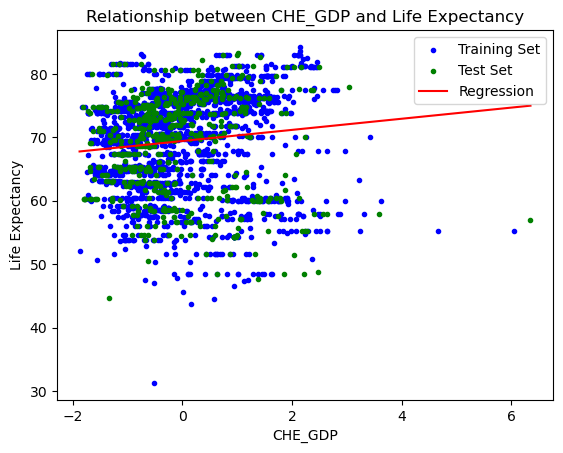

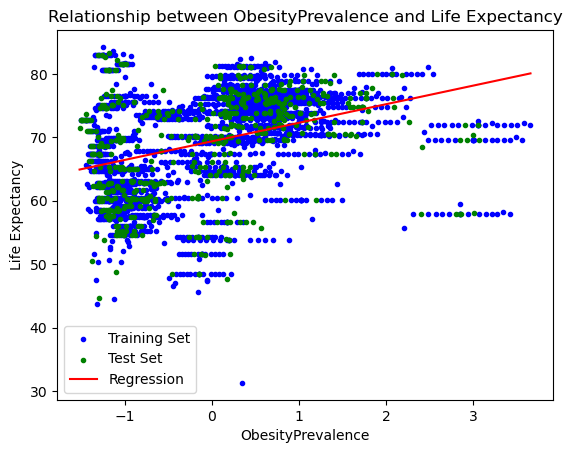

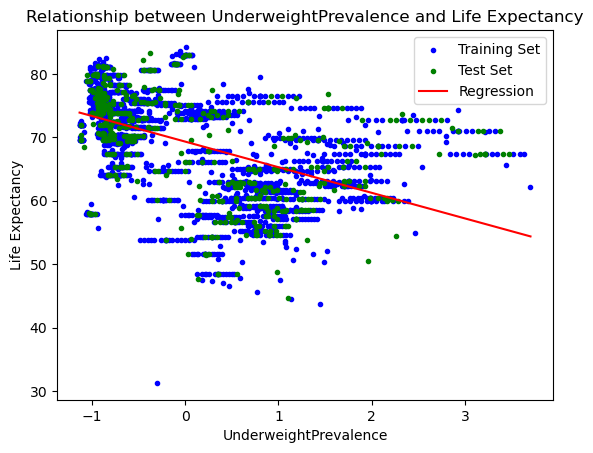

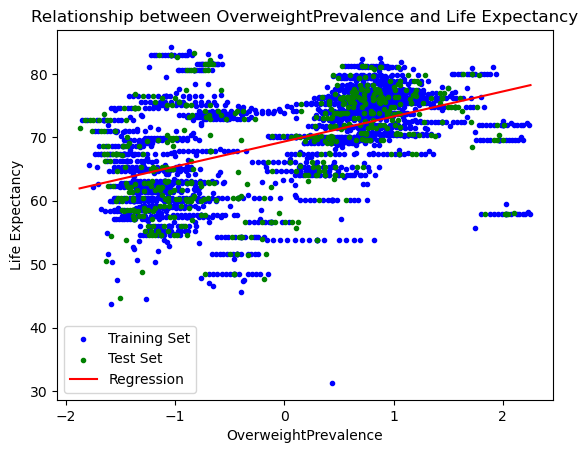

In [37]:
# Data that fills the NaN value with average value
X = data.drop(['LifeExpectancy', 'Year'], axis=1)
features = X.columns
y = data['LifeExpectancy'].to_numpy()
X = scale(X)

# Split the dataset into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for i in range(X.shape[1]):
    plt.figure()
    plt.scatter(X_train[:,i],y_train,marker='.',c='b',label='Training Set')
    plt.scatter(X_test[:,i], y_test,marker='.',c='g',label='Test Set')
    plt.title(f'Relationship between {features[i]} and Life Expectancy')
    plt.xlabel(features[i])
    plt.ylabel('Life Expectancy')
    
    # Train Univariate Linear Regression model on the training data 
    reg = LinearRegression()
    reg.fit(np.expand_dims(X_train[:,i],1), y_train)
    print(f'{features[i]}: reg_coef: {reg.coef_}, reg.intercept_: {reg.intercept_}')
    
    # Plot the regression line
    x_range = np.linspace(np.min(X[:,i]),np.max(X[:,i]),100)
    y_range = reg.predict(np.expand_dims(x_range,1))
    plt.plot(x_range, y_range, c='r',label='Regression')
    plt.legend()

In [38]:
# Do multiple train-test split against noisy split to measure the performance
splits = ShuffleSplit(n_splits=10, test_size=0.2, train_size=0.8, random_state=42)
mse = np.zeros((splits.get_n_splits(), X.shape[1], 2))

# Apply univariante linear regression on each train-test split
for i, (train_index, test_index) in enumerate(splits.split(X, y)):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    # Apply univariante linear regression on each feature
    for j in range(X.shape[1]):
        reg = LinearRegression()
        reg.fit(np.expand_dims(X_train[:, j], 1), y_train)
        
        # Compute the training MSE
        mse[i,j,0] = mean_squared_error(y_train, reg.predict(np.expand_dims(X_train[:, j], 1)))
        # Compute the test MSE
        mse[i,j,1] = mean_squared_error(y_test, reg.predict(np.expand_dims(X_test[:, j], 1)))


In [39]:
# Calculate std of mse
mse_train_uni = np.squeeze(mse[:,:,0])
mse_test_uni = np.squeeze(mse[:,:,1])
mse_train_uni_std = np.std(mse_train_uni, axis = 0)
mse_test_uni_std = np.std(mse_test_uni, axis = 0)
mse_reg_std[:12,0,0] = mse_train_uni_std
mse_reg_std[:12,1,0] = mse_test_uni_std

training_mse   test_mse
HepB3                     55.483407  56.225937
MCV1                      44.686099  45.198348
MCV2                      39.791718  40.506361
BCG                       57.185470  57.715803
Pol3                      45.054042  45.154502
AlcoholConsumption        54.509232  54.459796
TobaccoPrevalence         54.268382  55.261806
CHE_PPP                   37.794842  38.705099
CHE_GDP                   59.823798  61.044485
ObesityPrevalence         51.750086  53.304990
UnderweightPrevalence     44.790232  45.723583
OverweightPrevalence      44.922951  46.288412

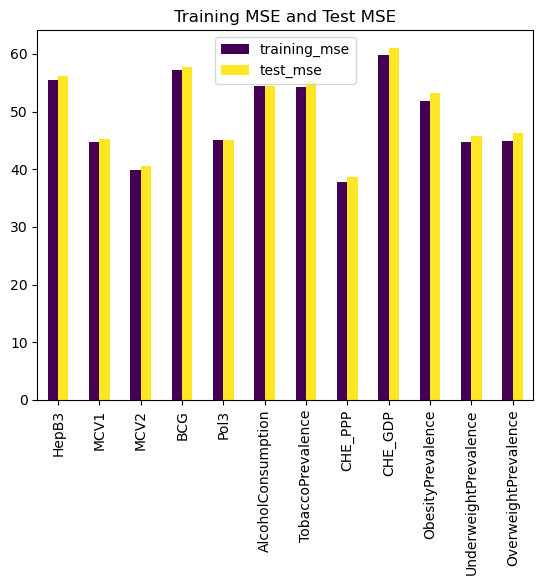

In [40]:
# Average the training and test MSE over different splits
mse = mse.mean(axis=0)
mse_reg[:12,:,0] = mse
mse = pd.DataFrame(mse,index=features,columns=['training_mse','test_mse'])
mse.plot(kind='bar', title = 'Training MSE and Test MSE',colormap='viridis')
mse

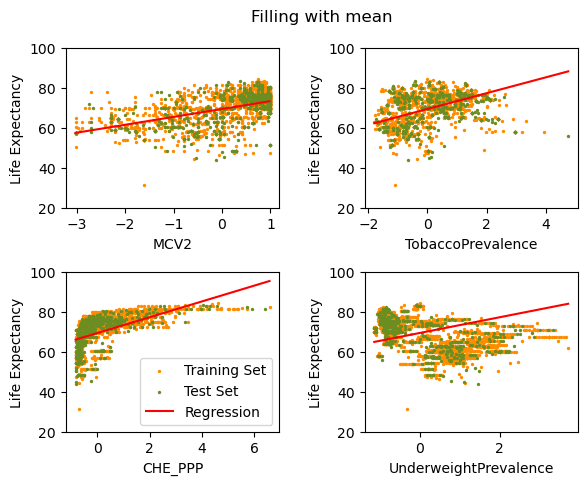

In [41]:
# Display four factors: CHE_PPP, MVC2, underweight, Tabacco in one plot
fig, axs = plt.subplots(2,2)
fig.suptitle('Relationship between predicting variables and Life Expectancy')
features_idx = [2,6,7,10]

for i,idx in enumerate(features_idx):
    ax = plt.subplot(2,2,i+1)
    ax.scatter(X_train[:,idx],y_train,marker='.',c='darkorange',s=8,label='Training Set')
    ax.scatter(X_test[:,idx], y_test,marker='.',c='olivedrab',s=8,label='Test Set')
    ax.set_xlabel(features[idx])
    ax.set_ylabel('Life Expectancy')
    ax.set_ylim([20, 100])
    
    # Plot the regression line
    x_range = np.linspace(np.min(X[:,idx]),np.max(X[:,idx]),100)
    y_range = reg.predict(np.expand_dims(x_range,1))
    ax.plot(x_range, y_range, c='r',label='Regression')
    if i == 2:
        ax.legend(loc='lower right')
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.4,
                        hspace=0.4)
    
fig.suptitle('Filling with mean')
fig.savefig('uni_scatter_fill.pdf',bbox_inches='tight')

###  Data that simply drops NaN value


HepB3: reg_coef: [1.38162355], reg.intercept_: 72.18716662536069
MCV1: reg_coef: [1.77117738], reg.intercept_: 72.15918352775698
MCV2: reg_coef: [2.69075832], reg.intercept_: 72.05010169015358
BCG: reg_coef: [1.77499862], reg.intercept_: 72.0428734152498
Pol3: reg_coef: [1.87420404], reg.intercept_: 72.16881267338803
AlcoholConsumption: reg_coef: [0.67304832], reg.intercept_: 72.1996012324464
TobaccoPrevalence: reg_coef: [0.48271336], reg.intercept_: 72.17954176165081
CHE_PPP: reg_coef: [3.54296017], reg.intercept_: 72.13193388401646
CHE_GDP: reg_coef: [0.61736292], reg.intercept_: 72.20514976470565
ObesityPrevalence: reg_coef: [1.32106837], reg.intercept_: 72.12857643177529
UnderweightPrevalence: reg_coef: [-2.46168484], reg.intercept_: 72.04864158659342
OverweightPrevalence: reg_coef: [1.95034905], reg.intercept_: 72.07284577258451


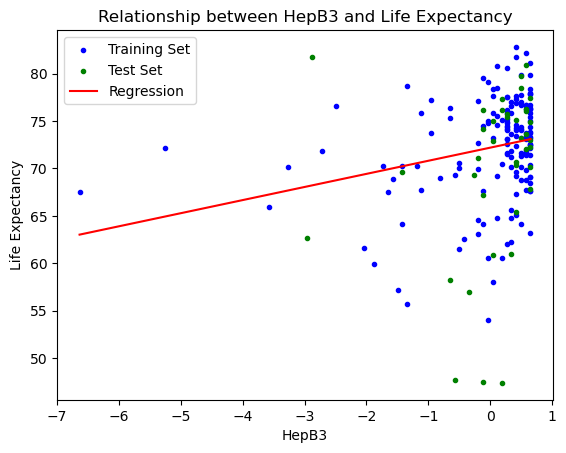

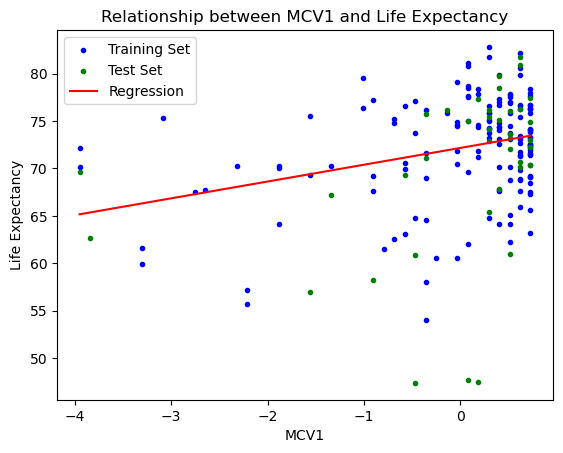

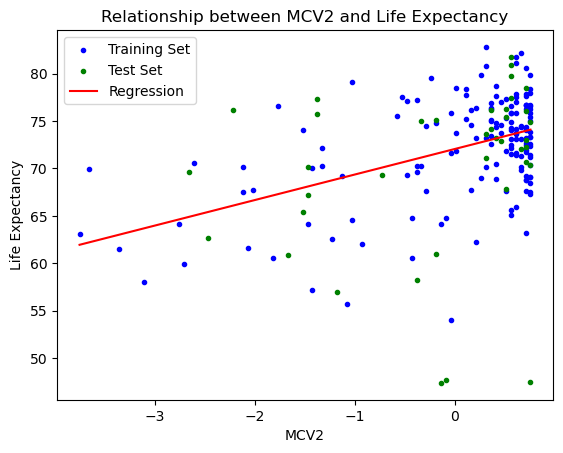

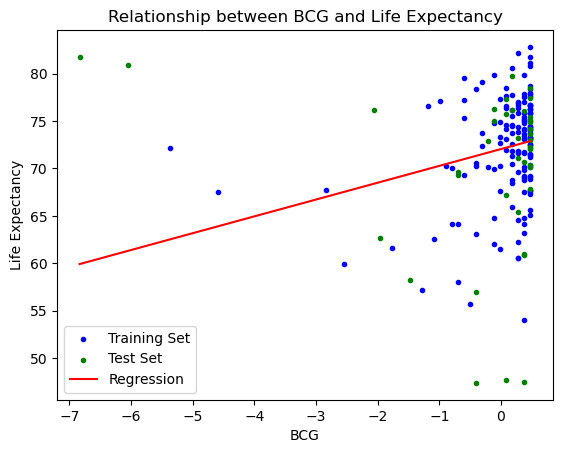

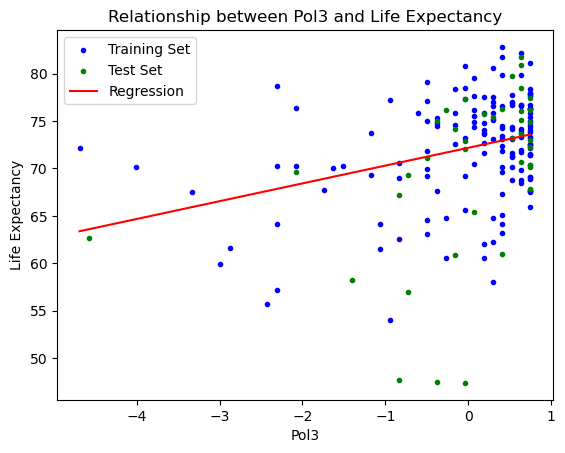

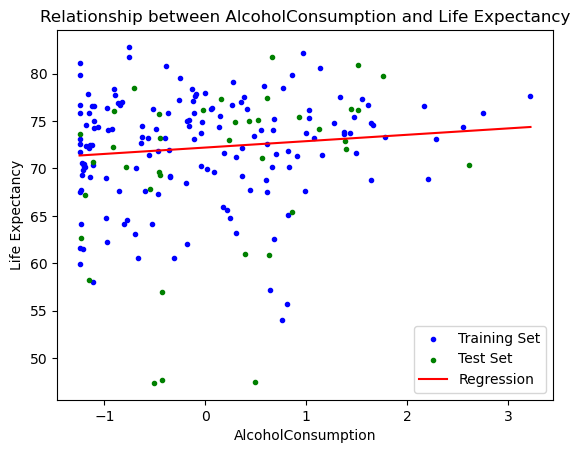

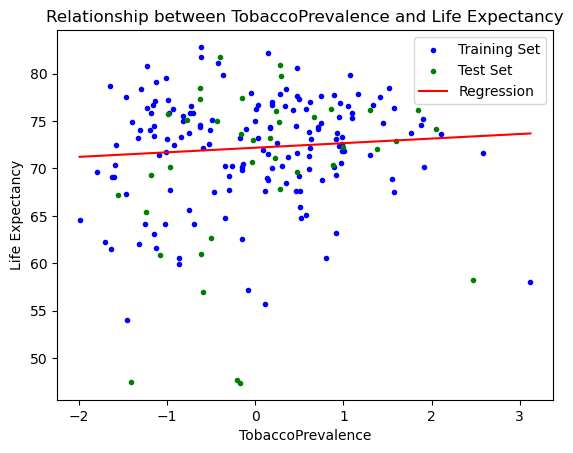

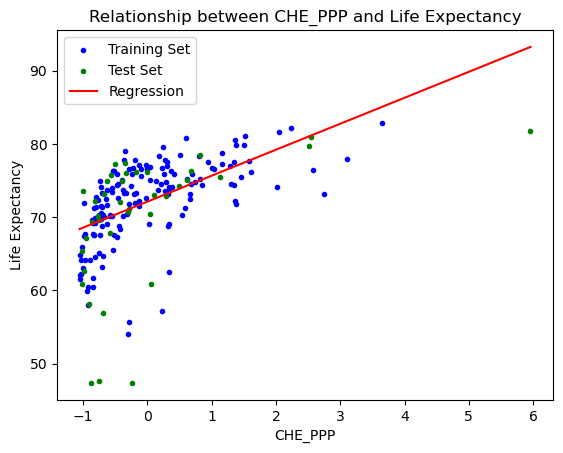

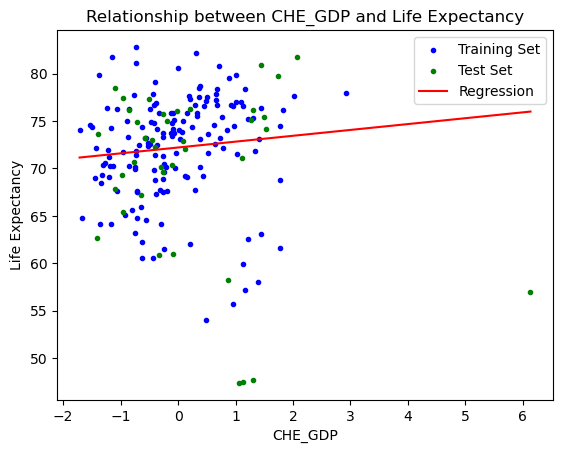

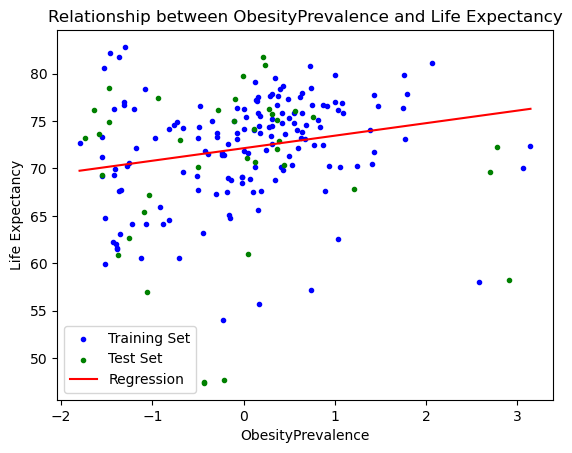

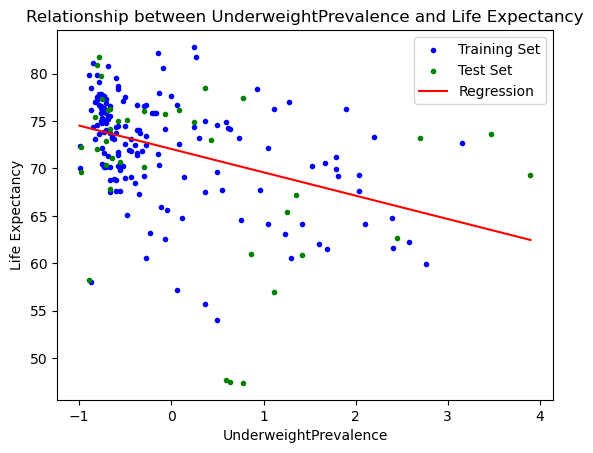

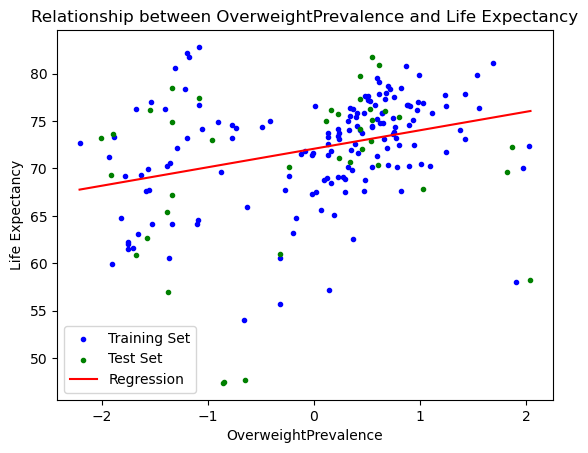

In [42]:
# Data that simply drops NaN value
X = data_dropna.drop(['LifeExpectancy','Year','Country'], axis=1)
features = X.columns
y = data_dropna['LifeExpectancy'].to_numpy()
X = scale(X)

# Split the dataset into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for i in range(X.shape[1]):
    plt.figure()
    plt.scatter(X_train[:,i],y_train,marker='.',c='b',label='Training Set')
    plt.scatter(X_test[:,i], y_test,marker='.',c='g',label='Test Set')
    plt.title(f'Relationship between {features[i]} and Life Expectancy')
    plt.xlabel(features[i])
    plt.ylabel('Life Expectancy')
    
    # Train Univariate Linear Regression model on the training data 
    reg = LinearRegression()
    reg.fit(np.expand_dims(X_train[:,i],1), y_train)
    print(f'{features[i]}: reg_coef: {reg.coef_}, reg.intercept_: {reg.intercept_}')
    
    # Plot the regression line
    x_range = np.linspace(np.min(X[:,i]),np.max(X[:,i]),100)
    y_range = reg.predict(np.expand_dims(x_range,1))
    plt.plot(x_range, y_range, c='r',label='Regression')
    plt.legend()

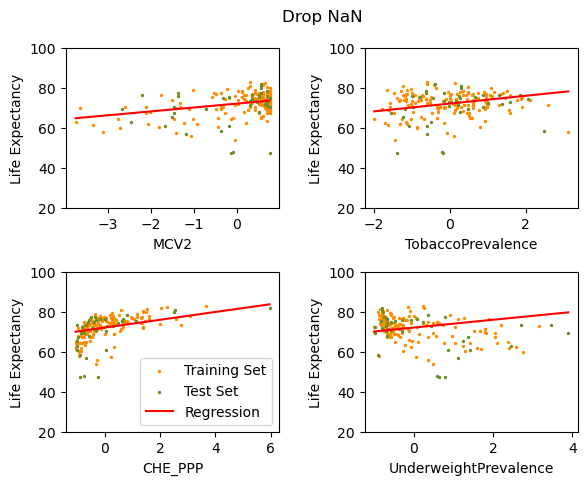

In [43]:
# Display four factors: CHE_PPP, MVC2, underweight, Tabacco in one plot
fig, axs = plt.subplots(2,2)
fig.suptitle('Relationship between predicting variables and Life Expectancy')
features_idx = [2,6,7,10]

for i,idx in enumerate(features_idx):
    ax = plt.subplot(2,2,i+1)
    ax.scatter(X_train[:,idx],y_train,marker='.',c='darkorange',s=8,label='Training Set')
    ax.scatter(X_test[:,idx], y_test,marker='.',c='olivedrab',s=8,label='Test Set')
    ax.set_xlabel(features[idx])
    ax.set_ylabel('Life Expectancy')
    ax.set_ylim([20, 100])
    
    # Plot the regression line
    x_range = np.linspace(np.min(X[:,idx]),np.max(X[:,idx]),100)
    y_range = reg.predict(np.expand_dims(x_range,1))
    ax.plot(x_range, y_range, c='r',label='Regression')
    if i == 2:
        ax.legend(loc='lower right')
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.4,
                        hspace=0.4)
    
    
fig.suptitle('Drop NaN')
fig.savefig('uni_scatter_dropna.pdf',bbox_inches='tight')

In [44]:
# Do multiple train-test split against noisy split to measure the performance
splits = ShuffleSplit(n_splits=100, test_size=0.2, train_size=0.8, random_state=42)
mse = np.zeros((splits.get_n_splits(), X.shape[1], 2))

# Apply univariante linear regression on each train-test split
for i, (train_index, test_index) in enumerate(splits.split(X, y)):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    # Apply univariante linear regression on each feature
    for j in range(X.shape[1]):
        reg = LinearRegression()
        reg.fit(np.expand_dims(X_train[:, j], 1), y_train)
        
        # Compute the training MSE
        mse[i,j,0] = mean_squared_error(y_train, reg.predict(np.expand_dims(X_train[:, j], 1)))
        # Compute the test MSE
        mse[i,j,1] = mean_squared_error(y_test, reg.predict(np.expand_dims(X_test[:, j], 1)))



In [45]:
# Calculate std of mse
mse_train_uni = np.squeeze(mse[:,:,0])
mse_test_uni = np.squeeze(mse[:,:,1])
mse_train_uni_std = np.std(mse_train_uni, axis = 0)
mse_test_uni_std = np.std(mse_test_uni, axis = 0)
mse_reg_std[:12,0,1] = mse_train_uni_std
mse_reg_std[:12,1,1] = mse_test_uni_std

training_mse   test_mse
HepB3                     37.795420  40.210219
MCV1                      35.955372  37.796343
MCV2                      33.283333  34.973452
BCG                       39.477699  43.583208
Pol3                      34.993659  36.787531
AlcoholConsumption        38.982408  40.905965
TobaccoPrevalence         39.215605  42.049668
CHE_PPP                   28.083022  29.733639
CHE_GDP                   39.711843  42.964684
ObesityPrevalence         38.712936  41.327737
UnderweightPrevalence     34.059676  36.090680
OverweightPrevalence      36.036026  38.249253

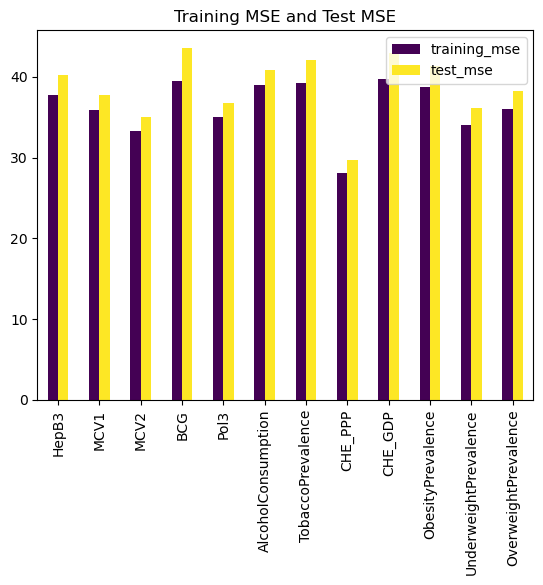

In [46]:
# Average the training and test MSE over different splits
mse = mse.mean(axis=0)
mse_reg[:12,:,1] = mse
mse = pd.DataFrame(mse,index=features,columns=['training_mse','test_mse'])
mse.plot(kind='bar', title = 'Training MSE and Test MSE',colormap='viridis')

mse

## Multivariate Linear Regression with LASSO Regularization ##

### Data that fills the NaN value with average value

In [47]:
# Data that fills the NaN value with average value
X = data.drop(['LifeExpectancy','Year'], axis=1)
features = X.columns
y = data['LifeExpectancy'].to_numpy()
X = scale(X)

# Split the dataset into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Multivariate Linear Regression model on the training data
# Use LassoCV to find the best alpha value
reg = LassoCV(cv=5, random_state=42)
reg.fit(X_train, y_train)
weights = {}
for i in range(len(features)):
    weights[features[i]] = reg.coef_[i]
print(weights)

{'HepB3': -0.22286110133923448, 'MCV1': 0.13595521153113266, 'MCV2': 1.554089744722178, 'BCG': 0.2461159939145354, 'Pol3': 0.8350801982503215, 'AlcoholConsumption': -0.514868840562186, 'TobaccoPrevalence': 0.9521651563649641, 'CHE_PPP': 2.8579722985417653, 'CHE_GDP': -1.0010283656298669, 'ObesityPrevalence': -9.189070549030477, 'UnderweightPrevalence': 1.7736925261140055, 'OverweightPrevalence': 12.192362092899476}


In [48]:
# Do multiple train-test split against noisy split to measure the performance
splits = ShuffleSplit(n_splits=100, test_size=0.2, train_size=0.8, random_state=42)
mse_train = np.zeros(splits.get_n_splits())
mse_test = np.zeros(splits.get_n_splits())

# Apply univariante linear regression on each train-test split
for i, (train_index, test_index) in enumerate(splits.split(X, y)):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    
    # Train Multivariate Linear Regression model on the training data
    # Use Cross validation to find the best alpha value
    reg = LassoCV(cv=5, random_state=42)
    reg.fit(X_train, y_train)
    
    # Compute the training and test MSE 
    mse_train[i] = mean_squared_error(y_train, reg.predict(X_train))
    mse_test[i] = mean_squared_error(y_test, reg.predict(X_test))


In [49]:
mse_train_mul_std = np.std(mse_train)
mse_test_mul_std = np.std(mse_test)
mse_reg_std[12,0,0]= mse_train_mul_std
mse_reg_std[12,1,0] = mse_test_mul_std

In [50]:
mse_train = mse_train.mean()
mse_test = mse_test.mean()
mse_reg[12,0,0] = mse_train
mse_reg[12,1,0] = mse_train
print(f'training_mse: {mse_train}, test_mse: {mse_test}')

training_mse: 21.351903389016005, test_mse: 21.368291398736464


### Data that simply drops NaN value

In [51]:
# Data that simply drops NaN value
X = data_dropna.drop(['LifeExpectancy','Year','Country'], axis=1)
features = X.columns
y = data_dropna['LifeExpectancy'].to_numpy()
X = scale(X)

# Split the dataset into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Multivariate Linear Regression model on the training data
# Use LassoCV to find the best alpha value
reg = LassoCV(cv=5, random_state=42)
reg.fit(X_train, y_train)
weights = {}
for i in range(len(features)):
    weights[features[i]] = reg.coef_[i]
print(weights)

{'HepB3': 0.36474484161963217, 'MCV1': -0.16783603001835146, 'MCV2': 1.245464465849778, 'BCG': -0.2889686228060989, 'Pol3': 0.3435459247412268, 'AlcoholConsumption': -0.7589537103366168, 'TobaccoPrevalence': 0.28914915021239673, 'CHE_PPP': 2.685717364732933, 'CHE_GDP': 0.21671951442836815, 'ObesityPrevalence': -4.448383258556885, 'UnderweightPrevalence': -0.4835336506532832, 'OverweightPrevalence': 4.488726915885432}


In [52]:
# Do multiple train-test split against noisy split to measure the performance
splits = ShuffleSplit(n_splits=100, test_size=0.2, train_size=0.8, random_state=42)
mse_train = np.zeros(splits.get_n_splits())
mse_test = np.zeros(splits.get_n_splits())

# Apply univariante linear regression on each train-test split
for i, (train_index, test_index) in enumerate(splits.split(X, y)):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    
    # Train Multivariate Linear Regression model on the training data
    # Use Cross validation to find the best alpha value
    reg = LassoCV(cv=5, random_state=42)
    reg.fit(X_train, y_train)
    
    # Compute the training and test MSE 
    mse_train[i] = mean_squared_error(y_train, reg.predict(X_train))
    mse_test[i] = mean_squared_error(y_test, reg.predict(X_test))

In [53]:
mse_train_mul_std = np.std(mse_train)
mse_test_mul_std = np.std(mse_test)
mse_reg_std[12,0,1]= mse_train_mul_std
mse_reg_std[12,1,1] = mse_test_mul_std

In [54]:
mse_train = mse_train.mean()
mse_test = mse_test.mean()
mse_reg[12,0,1] = mse_train
mse_reg[12,1,1] = mse_test
print(f'training_mse: {mse_train}, test_mse: {mse_test}')

training_mse: 19.60834070232753, test_mse: 24.807542054293243


In [55]:
# compare mse between data groups
mse_std_dropna_vs_fillmean = mse_reg_std[:,:,1]/ mse_reg_std[:,:,0]
mse_std_dropna_vs_fillmean

array([[5.18230298, 5.23154353],
       [4.69049095, 4.70015236],
       [4.45675904, 4.47101929],
       [6.91299308, 7.09570729],
       [5.42661624, 5.47157233],
       [5.29470432, 5.30130054],
       [3.83326492, 3.85062491],
       [4.76729113, 4.82812345],
       [4.39935222, 4.49384703],
       [3.95313788, 3.99628185],
       [5.10588494, 5.1378666 ],
       [4.02687393, 4.07514359],
       [4.25861515, 5.73906938],
       [4.76328894, 4.80222378]])

In [56]:
# fill with mean compare mse_std between trainig and test
mse_std_fillmean_train_test = mse_reg_std[:,1,0]/ mse_reg_std[:,0,0]
mse_std_fillmean_train_test

array([4.0224586 , 4.01820693, 4.01476013, 4.08042771, 4.0140066 ,
       4.03581627, 4.05592301, 3.99773178, 4.06899594, 4.02856851,
       4.02009248, 4.01770505, 4.01303324, 3.99841355])

In [57]:
# Drop NaN compare mse_std between trainig and test
mse_std_dropna_train_test = mse_reg_std[:,1,1]/ mse_reg_std[:,0,1]
mse_std_dropna_train_test

array([4.06067869, 4.02648358, 4.02760612, 4.18827566, 4.04726011,
       4.04084414, 4.07429136, 4.04874425, 4.15639494, 4.07253572,
       4.04527308, 4.0658648 , 5.408114  , 4.03109636])

### Sequential Feature Selection ###

In [58]:
# Data that fills the NaN value with average value
X = data.drop(['LifeExpectancy','Year'], axis=1)
features = X.columns
y = data['LifeExpectancy'].to_numpy()
X = scale(X)

# Train Multivariate Linear Regression model on the training data
reg = LinearRegression()
# Find the index of most important features using sequential feature selector
for i in range(1, X.shape[1]):
    sfs = SequentialFeatureSelector(reg, n_features_to_select=i, scoring ='neg_mean_squared_error',cv=5)
    sfs.fit(X_train, y_train)
    idx = sfs.get_support(indices=True)
    print(f'The most important {i} features are: {features[idx]}.')


The most important 1 features are: Index(['CHE_PPP'], dtype='object').
The most important 2 features are: Index(['Pol3', 'CHE_PPP'], dtype='object').
The most important 3 features are: Index(['Pol3', 'CHE_PPP', 'CHE_GDP'], dtype='object').
The most important 4 features are: Index(['Pol3', 'CHE_PPP', 'CHE_GDP', 'UnderweightPrevalence'], dtype='object').
The most important 5 features are: Index(['Pol3', 'CHE_PPP', 'CHE_GDP', 'ObesityPrevalence',
       'UnderweightPrevalence'],
      dtype='object').
The most important 6 features are: Index(['Pol3', 'CHE_PPP', 'CHE_GDP', 'ObesityPrevalence',
       'UnderweightPrevalence', 'OverweightPrevalence'],
      dtype='object').
The most important 7 features are: Index(['Pol3', 'AlcoholConsumption', 'CHE_PPP', 'CHE_GDP', 'ObesityPrevalence',
       'UnderweightPrevalence', 'OverweightPrevalence'],
      dtype='object').
The most important 8 features are: Index(['Pol3', 'AlcoholConsumption', 'TobaccoPrevalence', 'CHE_PPP', 'CHE_GDP',
       'Obesi

In [59]:
# Data that simply drops the NaN value
X = data_dropna.drop(['LifeExpectancy','Year','Country'], axis=1)
features = X.columns
y = data_dropna['LifeExpectancy'].to_numpy()
X = scale(X)

# Train Multivariate Linear Regression model on the training data
reg = LinearRegression()
# Find the index of most important features using sequential feature selector
for i in range(1, X.shape[1]):
    sfs = SequentialFeatureSelector(reg, n_features_to_select=i, scoring ='neg_mean_squared_error',cv=5)
    sfs.fit(X_train, y_train)
    idx = sfs.get_support(indices=True)
    print(f'The most important {i} features are: {features[idx]}.')

The most important 1 features are: Index(['CHE_PPP'], dtype='object').
The most important 2 features are: Index(['Pol3', 'CHE_PPP'], dtype='object').
The most important 3 features are: Index(['Pol3', 'CHE_PPP', 'CHE_GDP'], dtype='object').
The most important 4 features are: Index(['Pol3', 'CHE_PPP', 'CHE_GDP', 'UnderweightPrevalence'], dtype='object').
The most important 5 features are: Index(['Pol3', 'CHE_PPP', 'CHE_GDP', 'ObesityPrevalence',
       'UnderweightPrevalence'],
      dtype='object').
The most important 6 features are: Index(['Pol3', 'CHE_PPP', 'CHE_GDP', 'ObesityPrevalence',
       'UnderweightPrevalence', 'OverweightPrevalence'],
      dtype='object').
The most important 7 features are: Index(['Pol3', 'AlcoholConsumption', 'CHE_PPP', 'CHE_GDP', 'ObesityPrevalence',
       'UnderweightPrevalence', 'OverweightPrevalence'],
      dtype='object').
The most important 8 features are: Index(['Pol3', 'AlcoholConsumption', 'TobaccoPrevalence', 'CHE_PPP', 'CHE_GDP',
       'Obesi

### Data that fills the NaN value with average value

<Axes: title={'center': 'Training MSE and Test MSE'}>

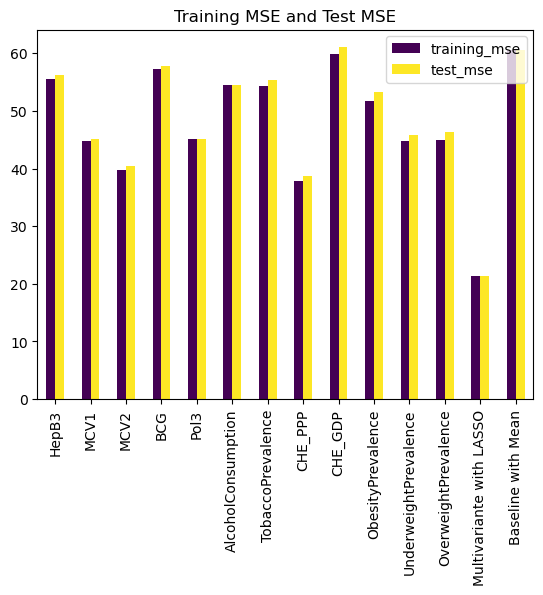

In [60]:
# Data that fills the NaN value with average value
mse_hist = pd.DataFrame(mse_reg[:,:,0],
                        index=features.append(pd.Index(['Multivariante with LASSO','Baseline with Mean'])),
                        columns=['training_mse','test_mse'])
mse_hist.plot(kind='bar',title = 'Training MSE and Test MSE',colormap='viridis')


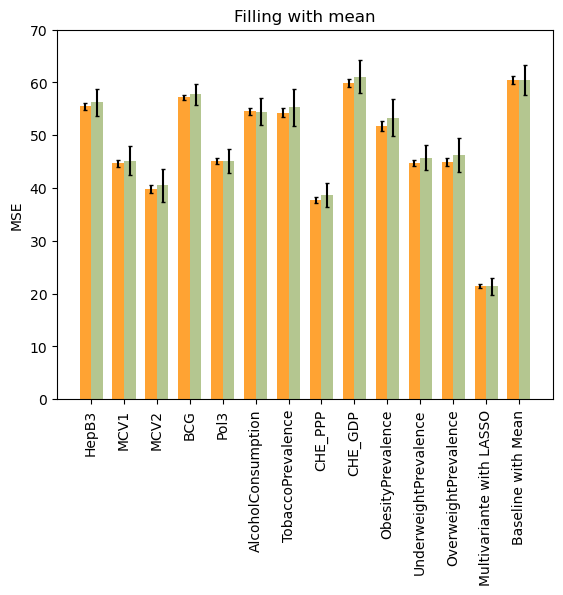

In [61]:
# plot mse across groups with error bar
labels = features.append(pd.Index(['Multivariante with LASSO','Baseline with Mean']))
x = np.arange(len(labels))  # the label locations
width = 0.35 # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse_reg[:,0,0], width, color='darkorange',label='train',yerr=mse_reg_std[:,0,0], align='center', alpha=0.8, ecolor='black', capsize=1.5)
rects2 = ax.bar(x + width/2, mse_reg[:,1,0], width, color='olivedrab',label='test',yerr=mse_reg_std[:,1,0], align='center', alpha=0.5, ecolor='black', capsize=1.5)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_title('Filling with mean')
ax.set_xticks(x, labels,rotation=90)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim([0,70])
fig.savefig('mse_fill.pdf',bbox_inches='tight')

### Data that simply drops the NaN value

<Axes: title={'center': 'Training MSE and Test MSE'}>

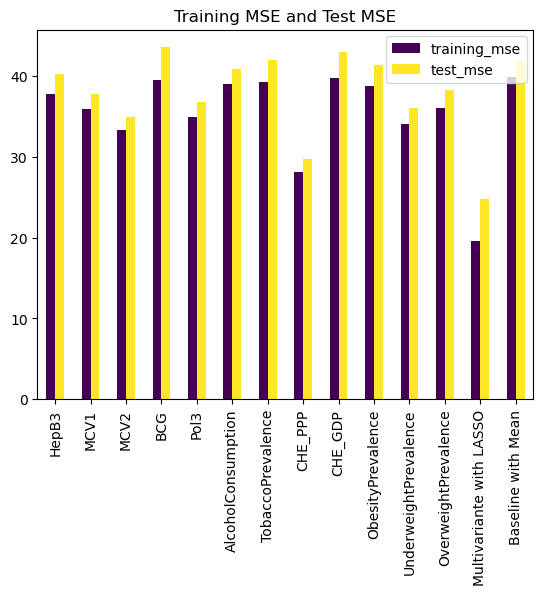

In [62]:
# Data that simply drops the NaN value
mse_hist = pd.DataFrame(mse_reg[:,:,1],
                        index=features.append(pd.Index(['Multivariante with LASSO','Baseline with Mean'])),
                        columns=['training_mse','test_mse'])
mse_hist.plot(kind='bar',title = 'Training MSE and Test MSE',colormap='viridis')

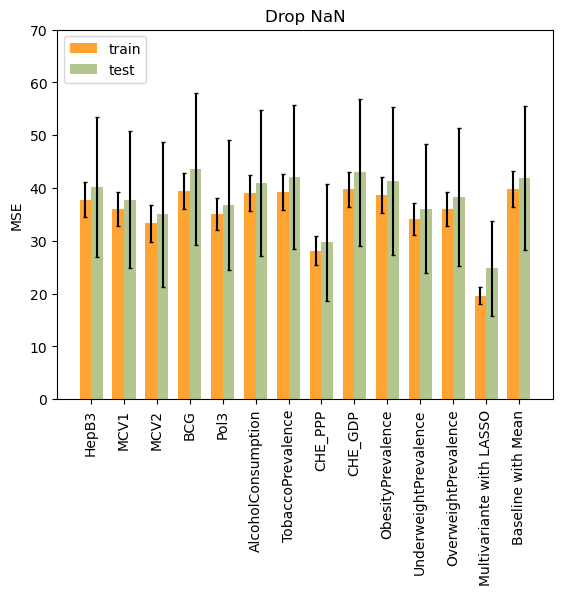

In [63]:
# plot mse across groups with error bar
labels = features.append(pd.Index(['Multivariante with LASSO','Baseline with Mean']))
x = np.arange(len(labels))  # the label locations
width = 0.35 # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse_reg[:,0,1], width,color='darkorange',label='train',yerr=mse_reg_std[:,0,1], align='center', alpha=0.8, ecolor='black', capsize=1.5,linewidth=0.1)
rects2 = ax.bar(x + width/2, mse_reg[:,1,1], width, color='olivedrab', label='test',yerr=mse_reg_std[:,1,1], align='center', alpha=0.5, ecolor='black', capsize=1.5)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_title('Drop NaN')
ax.set_xticks(x, labels,rotation=90)
ax.legend(loc='upper left')
ax.set_ylim([0,70])
fig.savefig('mse_dropna.pdf',bbox_inches='tight')

## Principal Component Regression ##

Text(0.5, 1.0, 'Cumulative explained variance ratio')

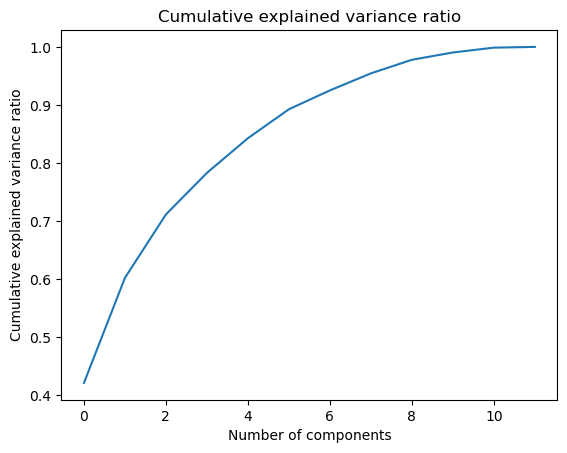

In [64]:
X = data.drop(['LifeExpectancy','Year'], axis=1)
y = data['LifeExpectancy']
X = scale(X)

pca = PCA()
X_reduced = pca.fit_transform(X)
cum_exp_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_exp_var)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance ratio')
plt.title('Cumulative explained variance ratio')


In [65]:
cum_exp_var

array([0.42159398, 0.60249285, 0.71161594, 0.78317174, 0.84284196,
       0.89270142, 0.9251391 , 0.95447247, 0.9778574 , 0.99042715,
       0.99877166, 1.        ])

In [66]:
# Split the dataset into training (80%) and test (20%) sets
X = data.drop(['LifeExpectancy','Year'], axis=1)
y = data['LifeExpectancy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

# Scale the training set
X_train = scale(X_train)
# Apply PCA on the training set, set n_component = 2
pca = PCA(n_components=2)
X_reduced_train = pca.fit_transform(X_train)
# Train Linear Regression model on training data 
reg = LinearRegression()
reg.fit(X_reduced_train, y_train)
print(reg.coef_)
print(reg.intercept_)

# Scale the test set
X_test = scale(X_test)
# Apply PCA on test set, set n_component = 2
pca = PCA(n_components=2)
X_reduced_test = pca.fit_transform(X_test)
# Make predictions 
y_test_pred = reg.predict(X_reduced_test)


[-2.21146794  0.37087075]
69.27499191312386


Text(0.5, 0.92, 'Life Expectancy (PCA n_component=2)')

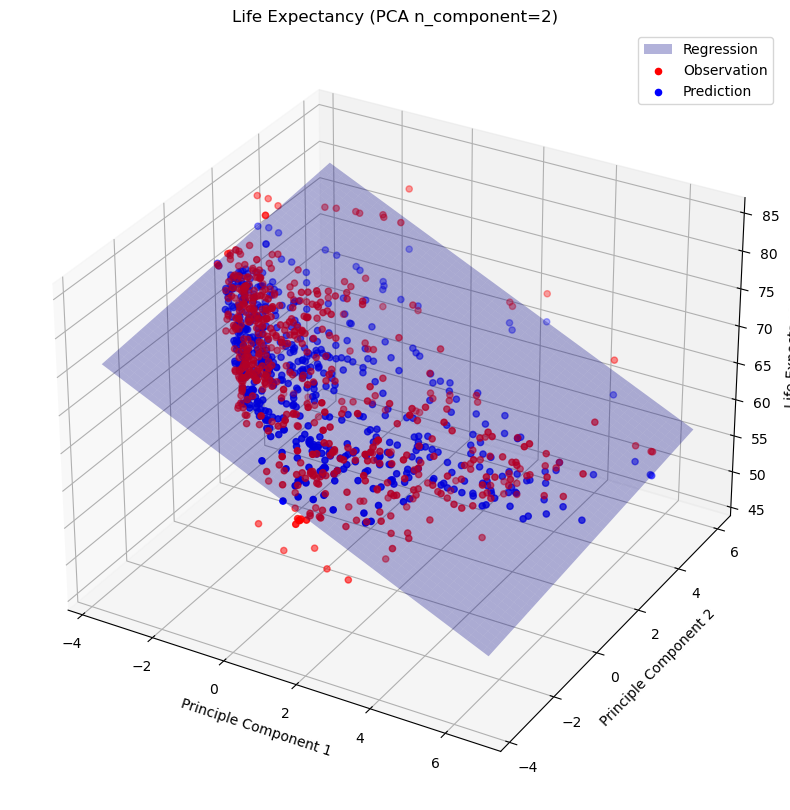

In [67]:
# Visualize our regression surface
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
X = np.arange(min(X_reduced_test[:,0]), max(X_reduced_test[:,0]), 0.001)
Y = np.arange(min(X_reduced_test[:,1]), max(X_reduced_test[:,1]), 0.001)
X, Y = np.meshgrid(X, Y)
Z = reg.coef_[0]*X + reg.coef_[1]*Y + reg.intercept_
surf = ax.plot_surface(X,Y,Z,color='b',alpha=0.3, label='Regression')
surf._edgecolors2d = surf._edgecolor3d
surf._facecolors2d = surf._facecolor3d
# Visualize our observations
ax.scatter(X_reduced_test[:,0], X_reduced_test[:,1], y_test, color='r', label='Observation')
# Visualize our predictions
ax.scatter(X_reduced_test[:,0], X_reduced_test[:,1], y_test_pred, color='b', label='Prediction')
ax.legend()
ax.set_xlabel('Principle Component 1')
ax.set_ylabel('Principle Component 2')
ax.set_zlabel('Life Expectancy')
ax.set_title('Life Expectancy (PCA n_component=2)')


In [68]:
X = data.drop(['LifeExpectancy','Year'], axis=1)
y = data['LifeExpectancy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
cv_scores = []
test_scores = []
for n in range(1,12):
    # Scale the training set
    X_train = scale(X_train)
    # Apply PCA on the training set, set n_component = n
    pca = PCA(n)
    X_reduced_train = pca.fit_transform(X_train)
    # Train Linear Regression model on training data 
    reg = LinearRegression()
    reg.fit(X_reduced_train, y_train)
    # Compute the MSE in cross validation groups
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores.append(-cross_val_score(reg, X_reduced_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean())
    
    # Scale the test set
    X_test = scale(X_test)
    # Apply PCA on test set, set n_component = n
    pca = PCA(n)
    X_reduced_test = pca.fit_transform(X_test)
    # Make predictions 
    y_test_pred = reg.predict(X_reduced_test)
    # Compute the MSE in test set
    test_scores.append(mean_squared_error(y_test, y_test_pred, squared=True))
print(cv_scores)
print(test_scores)

[35.95657113891248, 35.583706877954796, 35.1350892183056, 35.15818937377438, 29.3540469960085, 27.6492723106401, 27.396983315909573, 27.191173794158352, 27.16932658180381, 26.135672704455878, 26.10904261509711]
[33.66433425895987, 33.86540003587104, 33.062617187124836, 32.86746056399324, 26.43136234137623, 25.820192380194232, 25.400487051833714, 26.338562070590314, 26.611529542606856, 25.133140765738265, 25.243909874246743]


Text(0.5, 1.0, 'Mean Squared Error with different number of components')

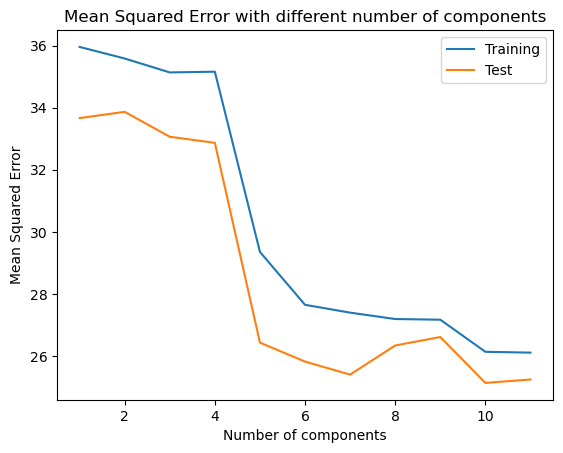

In [69]:
# Determine the number of component to choose
plt.plot(np.arange(1,12),cv_scores,label='Training')
plt.plot(np.arange(1,12),test_scores,label='Test')
plt.legend()
plt.xlabel('Number of components')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error with different number of components')

[-2.23931102  0.38536262  0.65568353 -0.02007498]
69.23929297597043


Text(0.5, 1.0, 'Prediction of life expectancy against observation on test set')

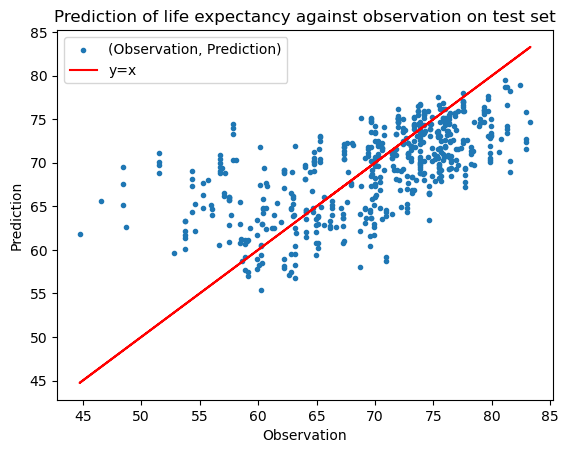

In [70]:
# Choose n_component = 6
# Split the dataset into training (80%) and test (20%) sets
X = data.drop(['LifeExpectancy','Year'], axis=1)
y = data['LifeExpectancy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

# Scale the training set
X_train = scale(X_train)
# Apply PCA on the training set, set n_component = 4
pca = PCA(n_components=4)
X_reduced_train = pca.fit_transform(X_train)
# Train Linear Regression model on training data 
reg = LinearRegression()
reg.fit(X_reduced_train, y_train)
print(reg.coef_)
print(reg.intercept_)

# Scale the test set
X_test = scale(X_test)
# Apply PCA on test set, set n_component = 4
pca = PCA(n_components=4)
X_reduced_test = pca.fit_transform(X_test)
# Make predictions 
y_test_pred = reg.predict(X_reduced_test)

plt.scatter(y_test, y_test_pred,marker='.',label='(Observation, Prediction)')
plt.xlabel('Observation')
plt.ylabel('Prediction')
plt.plot(y_test,y_test,c='r',label='y=x')
plt.legend()
plt.title('Prediction of life expectancy against observation on test set')
